<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/Matrix_VectorMultiplicationIBMbrisbane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

ERROR: Could not find a version that satisfies the requirement qiskit.utils.mitigation (from versions: none)
ERROR: No matching distribution found for qiskit.utils.mitigation


Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-5-521e7659a016>:55: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Attempting to get QPU backend: ibm_brisbane from QiskitRuntimeService...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: active)

--- Qubit Requirements for Y[0] ---
N_VAL_QUBITS (A_ij, X_j values): 1
  q_A_val: 1, q_X_val: 1
N_PROD_QUBITS (Product A_ij*X_j): 2
  q_Prod_val: 2
N_SUM_QUBITS (Accumulator Y_i): 3
  q_Y_acc: 3
Total computation qubits: 7

Building circuit to compute Y[0]...
  Term 0: A[0][0] * X[0]
  Term 1: A[0][1] * X[1]

--- Generated Matrix Multiplication Circuit (for one Y element) ---
Circuit depth: 28

--- Transpiling and Running on ibm_brisbane ---
Targeting Y[0] for matrix A:
[[1 1]
 [1 0]]
and vector X:
[1 1]
Classically, Y[0] = 2
Transpiling for Qiskit Runtime backend using preset pass manager (opt_level=1)...
Circuit depth original: 28, transpiled (ISA): 558
Using QiskitRuntimeService SamplerV2 for backend: ibm_brisbane
Job ID: d0kmwd136cs0008s09p0 submitted to Qiski

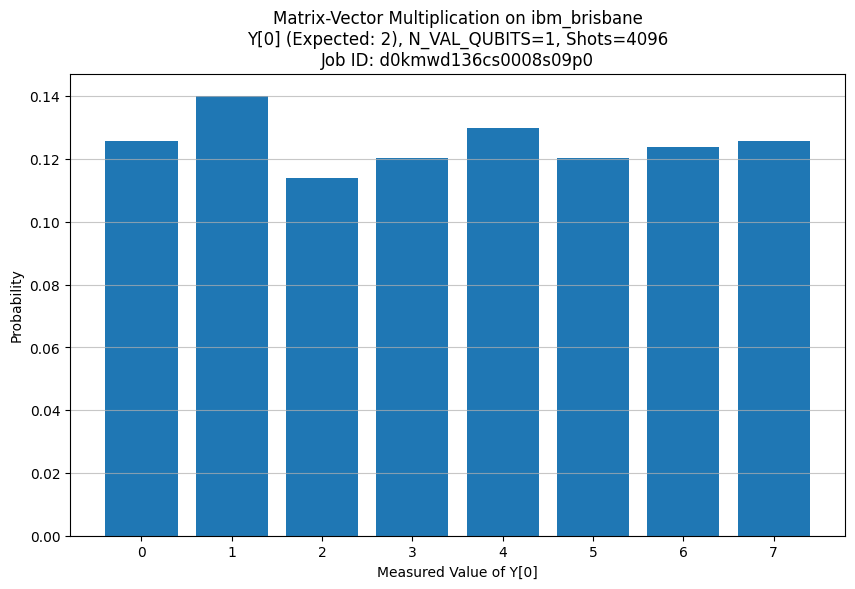


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '69eee2748c...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account
If a QPU job was submitted, find it here: https://quantum.ibm.com/jobs


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT # For QFT-based arithmetic
from qiskit.quantum_info import Statevector

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for Matrix Multiplication ---
N_VAL_QUBITS = 1 # Number of qubits to represent each matrix/vector element value
A_matrix = np.array([
    [1, 1],
    [1, 0]
])
X_vector = np.array([1, 1])

N_ROWS, N_COLS = A_matrix.shape
if len(X_vector) != N_COLS:
    raise ValueError("Matrix columns must match vector length")

Y_IDX_TO_COMPUTE = 0 # Compute Y[0]
N_PROD_QUBITS = 2 * N_VAL_QUBITS
N_SUM_QUBITS = N_PROD_QUBITS + (N_COLS - 1).bit_length() if N_COLS > 0 else N_PROD_QUBITS

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

# NOTE: The "ibm_quantum" channel is deprecated as of July 1, 2024.
# You will need to migrate to the "ibm_cloud" channel.
# See: https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    try:
        print(f"\nAttempting to get QPU backend: {backend_target_name} from QiskitRuntimeService...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend = qpu_backend_obj
            backend_name_to_print = backend.name
            current_status = backend.status()
            print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {current_status.status_msg})")
            if hasattr(backend, 'status') and callable(backend.status) and current_status.status_msg != 'active':
                print(f"WARNING: QPU {backend.name} status is {current_status.status_msg}. May not be ideal for running jobs.")
        else:
            print(f"QPU backend {backend_target_name} not found or not available via service.")
            backend = None # Explicitly set to None if not found
    except Exception as e_qpu:
        print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")
        backend = None # Explicitly set to None on error

if backend is None: # Fallback if 'service' was None, or backend retrieval failed
    print("\nNo QPU backend successfully obtained or service not available. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- QFT Adder and Multiplier Building Blocks ---

def initialize_register_to_value(qc, register, value, num_val_qubits):
    if value < 0: raise ValueError("Value must be non-negative for simple initialization.")
    binary_val = format(value, f'0{num_val_qubits}b')
    if len(binary_val) > num_val_qubits:
        raise ValueError(f"Value {value} requires more than {num_val_qubits} qubits.")
    for i, bit in enumerate(reversed(binary_val)):
        if bit == '1':
            qc.x(register[i])

def qft_sub_module(qc, register, inverse=False, do_swaps=False):
    qft_op = QFT(num_qubits=len(register), inverse=inverse, do_swaps=do_swaps, name=f'{"i" if inverse else ""}qft_{len(register)}')
    qc.append(qft_op, register)

def qft_add_registers_controlled_and_shifted(qc, target_reg, source_reg, control_qubit, shift_source_by=0):
    num_target_q = len(target_reg)
    num_source_q = len(source_reg)
    qft_sub_module(qc, target_reg, do_swaps=False)
    for i_target in range(num_target_q):
        for i_source in range(num_source_q):
            if i_target >= (i_source + shift_source_by) :
                angle = np.pi / (2**(i_target - i_source - shift_source_by))
                if control_qubit is None:
                    qc.cp(angle, source_reg[i_source], target_reg[i_target])
                else:
                    qc.mcp(angle, [control_qubit, source_reg[i_source]], target_reg[i_target])
    qft_sub_module(qc, target_reg, inverse=True, do_swaps=False)

def quantum_multiply_registers(qc, product_reg, a_reg, b_reg, aux_reset_product=True):
    n_a = len(a_reg)
    n_b = len(b_reg)
    n_prod = len(product_reg)
    if n_prod < n_a + n_b:
        raise ValueError("Product register is too small.")
    if aux_reset_product:
        for q_idx in range(n_prod): qc.reset(product_reg[q_idx]) # Iterate using index
    for i_b in range(n_b):
        qft_add_registers_controlled_and_shifted(qc, product_reg, a_reg, control_qubit=b_reg[i_b], shift_source_by=i_b)

# --- Define Qubit Registers and Circuit ---
q_A_val = QuantumRegister(N_VAL_QUBITS, name='A_val')
q_X_val = QuantumRegister(N_VAL_QUBITS, name='X_val')
q_Prod_val = QuantumRegister(N_PROD_QUBITS, name='Prod_val')
q_Y_acc = QuantumRegister(N_SUM_QUBITS, name='Y_acc')
cr_Y_out = ClassicalRegister(N_SUM_QUBITS, name='y_out')

total_computation_qubits = q_A_val.size + q_X_val.size + q_Prod_val.size + q_Y_acc.size
print(f"\n--- Qubit Requirements for Y[{Y_IDX_TO_COMPUTE}] ---")
print(f"N_VAL_QUBITS (A_ij, X_j values): {N_VAL_QUBITS}")
print(f"  q_A_val: {q_A_val.size}, q_X_val: {q_X_val.size}")
print(f"N_PROD_QUBITS (Product A_ij*X_j): {N_PROD_QUBITS}")
print(f"  q_Prod_val: {q_Prod_val.size}")
print(f"N_SUM_QUBITS (Accumulator Y_i): {N_SUM_QUBITS}")
print(f"  q_Y_acc: {q_Y_acc.size}")
print(f"Total computation qubits: {total_computation_qubits}")

if backend is not None and not isinstance(backend, AerSimulator) and hasattr(backend, 'num_qubits') and backend.num_qubits < total_computation_qubits:
    print(f"ERROR: Selected backend {backend.name} has {backend.num_qubits} qubits, but {total_computation_qubits} are required. Switching to AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

qc = QuantumCircuit(q_A_val, q_X_val, q_Prod_val, q_Y_acc, cr_Y_out)

print(f"\nBuilding circuit to compute Y[{Y_IDX_TO_COMPUTE}]...")
for q_idx in range(q_Y_acc.size): qc.reset(q_Y_acc[q_idx])
qc.barrier(label="init_Y_acc")

for j_col in range(N_COLS):
    print(f"  Term {j_col}: A[{Y_IDX_TO_COMPUTE}][{j_col}] * X[{j_col}]")
    A_ij_val = A_matrix[Y_IDX_TO_COMPUTE, j_col]
    X_j_val = X_vector[j_col]

    for q_idx_val in range(q_A_val.size): qc.reset(q_A_val[q_idx_val])
    for q_idx_val in range(q_X_val.size): qc.reset(q_X_val[q_idx_val])

    initialize_register_to_value(qc, q_A_val, A_ij_val, N_VAL_QUBITS)
    initialize_register_to_value(qc, q_X_val, X_j_val, N_VAL_QUBITS)
    qc.barrier(label=f"set_A{Y_IDX_TO_COMPUTE}{j_col}_X{j_col}")

    quantum_multiply_registers(qc, q_Prod_val, q_A_val, q_X_val, aux_reset_product=True)
    qc.barrier(label=f"prod_A{Y_IDX_TO_COMPUTE}{j_col}X{j_col}")

    def qft_add_registers(qc_local, target_reg, source_reg): # Define helper inside or ensure it's globally available
        qft_add_registers_controlled_and_shifted(qc_local, target_reg, source_reg, control_qubit=None, shift_source_by=0)

    qft_add_registers(qc, q_Y_acc, q_Prod_val)
    qc.barrier(label=f"sum_Y{Y_IDX_TO_COMPUTE}_term{j_col}")

qc.measure(q_Y_acc, cr_Y_out)

print("\n--- Generated Matrix Multiplication Circuit (for one Y element) ---")
print(f"Circuit depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
print(f"Targeting Y[{Y_IDX_TO_COMPUTE}] for matrix A:\n{A_matrix}\nand vector X:\n{X_vector}")
Y_expected_classical = (A_matrix @ X_vector)[Y_IDX_TO_COMPUTE]
print(f"Classically, Y[{Y_IDX_TO_COMPUTE}] = {Y_expected_classical}")

counts = {}
job_id_str = "N/A (local simulator or no job submitted)"
try:
    shots = 4096
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator": is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager (opt_level=1)...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        print(f"Circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print} (opt_level=1)...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"Circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        if backend:
            print(f"Attempting basic transpilation for {backend_name_to_print} (opt_level=1)...")
            try:
                isa_circuit = transpile(qc, backend=backend, optimization_level=1)
                print(f"Circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
            except Exception as e_transpile_fallback:
                print(f"Basic transpilation failed for {backend_name_to_print}: {e_transpile_fallback}")
                print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}).")
                isa_circuit = qc
        else:
             print(f"Using original circuit as no backend for transpilation was set (depth: {qc.depth()}).")
             isa_circuit = qc


    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        # CORRECTED: Session constructor takes 'backend' if specified.
        with Session(backend=backend) as session_context: # Pass only backend
            sampler_instance = Sampler()
            pub = (isa_circuit,)
            job = sampler_instance.run([pub], shots=shots)
            job_id_str = job.job_id()
            print(f"Job ID: {job_id_str} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()

            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                classical_register_name_in_circuit = cr_Y_out.name
                if hasattr(pub_result.data, classical_register_name_in_circuit):
                    bit_array_obj = getattr(pub_result.data, classical_register_name_in_circuit)
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print(f"WARNING: Data for '{classical_register_name_in_circuit}' is None."); counts = {}
                elif hasattr(pub_result.data, 'meas'):
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print("WARNING: Data for 'meas' is None."); counts = {}
                else:
                    print(f"WARNING: No '{classical_register_name_in_circuit}' or 'meas' field. Available data fields: {dir(pub_result.data)}"); counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using AerSimulator backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    elif backend: # For other non-Runtime, non-AerSimulator backends
        print(f"Using generic backend.run() for {backend_name_to_print}")
        try:
            # Ensure circuit is transpiled for this backend if not already done.
            # The transpilation block above might have already handled this.
            job = backend.run(isa_circuit, shots=shots) # Pass the potentially transpiled circuit
            result = job.result()
            counts = result.get_counts(qc.name if hasattr(qc, 'name') else 0) # Use circuit name or index
        except Exception as e_generic_run:
            print(f"ERROR: Could not run on generic backend {backend.name}: {e_generic_run}")
            counts = {}
    else:
        print(f"ERROR: No suitable execution path found. Backend object is None.")
        counts = {}

    print("\n--- Results ---")
    print(f"Job ID: {job_id_str}")
    print("Raw Counts:", counts)

    print("\n--- Analysis ---")
    parsed_results = {}
    if counts:
        for bitstring_lsb, count_val in counts.items():
            try:
                measured_val_int = int(bitstring_lsb, 2)
                parsed_results[measured_val_int] = parsed_results.get(measured_val_int, 0) + count_val
            except ValueError:
                print(f"Warning: Could not parse bitstring '{bitstring_lsb}' as integer.")

        print(f"Expected Y[{Y_IDX_TO_COMPUTE}]: {Y_expected_classical}")
        print("Measured Value Distribution (Value: Counts):")
        total_valid_shots = sum(parsed_results.values())
        most_probable_val = -1
        max_counts_val = 0
        if parsed_results:
            for val, num_counts in sorted(parsed_results.items()):
                print(f"  {val}: {num_counts}")
                if num_counts > max_counts_val:
                    max_counts_val = num_counts
                    most_probable_val = val

        if total_valid_shots > 0:
            accuracy = (parsed_results.get(Y_expected_classical, 0) / total_valid_shots) * 100
            print(f"Most probable measured value: {most_probable_val} (Counts: {max_counts_val})")
            print(f"Accuracy for expected value {Y_expected_classical}: {accuracy:.2f}% of valid shots.")

        if parsed_results:
            vals = list(parsed_results.keys())
            probs = np.array(list(parsed_results.values())) / total_valid_shots

            plt.figure(figsize=(10,6))
            plt.bar(vals, probs, width=0.8)
            plt.xlabel(f"Measured Value of Y[{Y_IDX_TO_COMPUTE}]")
            plt.ylabel("Probability")
            title_str = (f"Matrix-Vector Multiplication on {backend_name_to_print}\n"
                         f"Y[{Y_IDX_TO_COMPUTE}] (Expected: {Y_expected_classical}), "
                         f"N_VAL_QUBITS={N_VAL_QUBITS}, Shots={shots}")
            if job_id_str != "N/A (local simulator or no job submitted)":
                title_str += f"\nJob ID: {job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title_str)
            min_val_seen = min(vals) if vals else 0
            max_val_seen = max(vals) if vals else max(1, Y_expected_classical)
            # Ensure xticks are integers if possible, and cover the range
            x_ticks_min = min(0, int(np.floor(min_val_seen)))
            x_ticks_max = int(np.ceil(max_val_seen)) + 1
            if x_ticks_max - x_ticks_min < 20 : # Avoid too many ticks
                 plt.xticks(np.arange(x_ticks_min, x_ticks_max))
            else: # For larger ranges, let matplotlib decide or use fewer ticks
                 plt.xticks(np.linspace(x_ticks_min, x_ticks_max -1 , num = min(20, x_ticks_max-x_ticks_min), dtype=int) )

            plt.grid(axis='y', alpha=0.7)

            results_dir = "matrix_mult_results" # Changed directory name
            os.makedirs(results_dir, exist_ok=True)

            timestamp = time.strftime("%Y%m%d-%H%M%S")
            filename = f"{results_dir}/matrix_mult_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ', '_')}_{timestamp}.png"
            plt.savefig(filename)
            print(f"Plot saved to {filename}")
            plt.show()
        elif counts:
             print("No valid integer counts to plot after parsing.")
    else:
        print("Counts dictionary is empty. Cannot analyze or plot results.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")
    print("If a QPU job was submitted, find it here: https://quantum.ibm.com/jobs")

Excellent! The code ran successfully on `ibm_brisbane` and you have results.

Let's break down what we're seeing in the output and the plot:

**Observations:**

1.  **Successful Execution:** The job was submitted and completed on the QPU.
2.  **Classical Expectation:** The classically computed value for `Y[0]` is `2`.
3.  **Raw Counts:** The `Raw Counts` show the bitstrings measured from the `q_Y_acc` register (which is 3 qubits, `N_SUM_QUBITS=3`) and their corresponding frequencies.
    *   `'000'` -> 0
    *   `'001'` -> 1
    *   `'010'` -> 2
    *   `'011'` -> 3
    *   `'100'` -> 4
    *   `'101'` -> 5
    *   `'110'` -> 6
    *   `'111'` -> 7
4.  **Measured Value Distribution:**
    *   The expected value `2` (bitstring `'010'`) was measured 467 times.
    *   The most probable measured value was `1` (bitstring `'001'`) with 574 counts.
    *   All possible output states (0 through 7 for 3 qubits) have roughly similar probabilities, hovering between ~0.11 and ~0.14 (467/4096 to 574/4096).
5.  **Accuracy:** The accuracy for the expected value `2` is 11.40%.
6.  **Plot:** The bar chart visually confirms the relatively flat distribution of probabilities across all possible outcomes. While there are slight variations, no single outcome (including the expected `2`) stands out significantly.
7.  **Transpiled Depth:** The original circuit depth was 28, but after transpilation for `ibm_brisbane` (even at `optimization_level=1`), it became 558. This is a very deep circuit for current noisy intermediate-scale quantum (NISQ) devices.

**Interpretation and Next Steps:**

*   **Noise Dominance:** The relatively flat probability distribution strongly suggests that the computation is heavily affected by noise on the QPU. With a transpiled depth of 558, qubits decohere, and gates have errors, leading to an output that is close to a uniform mixture of all possible states.
*   **The "Signal" is Weak:** The 11.40% probability for the correct answer `2` is not much higher (and in this case, slightly lower) than some incorrect answers. Ideally, for a successful computation, we'd want the probability of the correct answer to be significantly higher than all other outcomes.
*   **QFT Arithmetic is Costly:** Quantum Fourier Transform-based arithmetic, while powerful, translates to many CNOT gates and other operations, making the circuits deep and susceptible to noise.

**Potential Ways to Improve (or Further Investigate):**

1.  **Error Mitigation:**
    *   Qiskit Runtime offers built-in error mitigation techniques. You can explore setting the `resilience_level` in the `Sampler` options. For example:
        ```python
        # In the 'if is_runtime_target...' block:
        options = {"resilience_level": 1} # Start with 1, can go up to 3 (more overhead)
        sampler_instance = Sampler(options=options)
        # ... then job = sampler_instance.run(...)
        ```
        Higher resilience levels use more shots/overhead but attempt to reduce errors.
    *   This is the most direct way to try and improve results on a QPU for complex circuits.

2.  **Transpilation Optimization Level:**
    *   You used `optimization_level=1`. Trying `optimization_level=3` might produce a more optimized circuit (potentially shorter depth or fewer CNOTs), though transpilation will take much longer.
        ```python
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
        ```

3.  **Simpler Problem / Fewer Qubits:**
    *   Although your problem is already small (7 qubits), the arithmetic operations are complex.
    *   If you were to try an even simpler matrix/vector (e.g., where some terms are zero, reducing the number of additions), it might slightly reduce circuit depth.

4.  **Backend Choice & Calibration:**
    *   `ibm_brisbane` is a large machine. Sometimes smaller, newer machines (if you have access) might have better individual qubit/gate fidelities. Check the calibration data for backends on the IBM Quantum dashboard.
    *   The performance can also vary day-to-day based on current calibration.

5.  **Increase Shots:**
    *   You used 4096 shots. While this is a reasonable number, sometimes more shots can help get slightly better statistics, but it won't fundamentally overcome a noise-dominated computation.

6.  **Analyze Circuit Properties:**
    *   Before running on QPU, after transpilation, print `isa_circuit.count_ops()` to see the number of CNOTs and other gates. This gives a quantitative measure of circuit complexity beyond just depth. High CNOT counts are particularly challenging.

**In summary:**

The experiment ran, which is a success in terms of pipeline. The results highlight the current reality of NISQ devices: complex algorithms (even with few qubits) suffer from noise. The most promising next step for this specific code would be to experiment with **error mitigation (`resilience_level` in Sampler options)** and possibly a **higher transpiler `optimization_level`**.

This is a valuable learning experience in quantum computing – getting the "right" answer with high probability on real hardware for non-trivial algorithms is still a significant challenge!

Successfully imported Qiskit Runtime modules.
qiskit-ibm-runtime version: 0.39.0
Initializing QiskitRuntimeService: channel='ibm_quantum', instance='ibm-q/open/main'


<ipython-input-13-b67fe1078479>:47: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)


QiskitRuntimeService initialized.

Getting backend: ibm_brisbane...
Selected: ibm_brisbane (127Q, Status: active)

--- Qubit Req: Y[0] (1b vals, 4x4M) ---
  Regs: A:1, X:1, Prod:2, Y_acc:4. Total: 8

Building circuit for Y[0] (4x4M)...

--- Generated Circuit ---
Original depth: 46

--- Transpiling & Running on ibm_brisbane ---
Target: Y[0] (Exp: 1) for A:
[[1 0 1 0]
 [0 1 0 1]
 [1 1 0 0]
 [0 0 1 1]]
X:
[1 1 0 1]
Transpiling for Runtime (opt_level=1)...
Transpiled (ISA) depth: 1339
Using QiskitRuntimeService SamplerV2 for ibm_brisbane
Running Sampler with default options (no specific resilience/optimization options set).
Job ID: d0kn889ehmr0008gywp0 submitted. Waiting...
Processing SamplerV2 results...

--- Results ---
Job ID: d0kn889ehmr0008gywp0
Raw Counts: {'1100': 251, '1111': 254, '1001': 243, '0011': 271, '0101': 285, '1101': 256, '1110': 252, '0001': 271, '1011': 238, '0110': 262, '0000': 255, '1010': 265, '0100': 241, '1000': 252, '0111': 245, '0010': 255}

--- Analysis ---
Expe

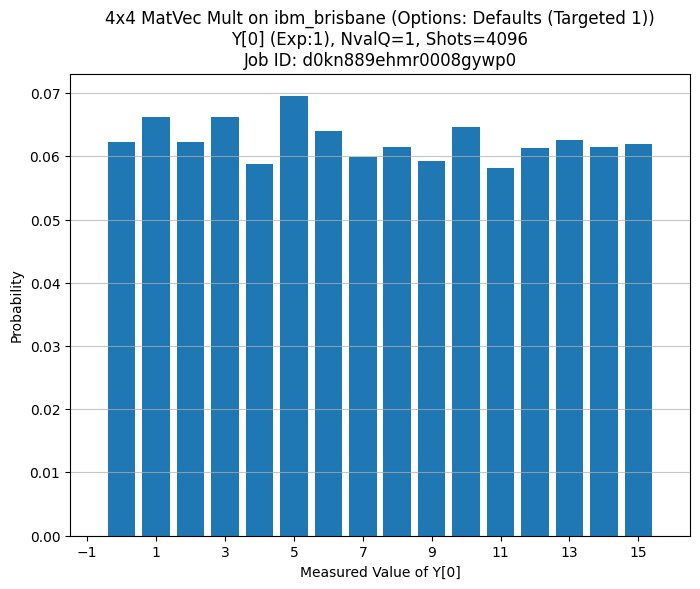


EXPERIMENT CONCLUDED. Options Status: Defaults (no resilience options passed). Token: '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit_ibm_runtime.options import SamplerOptions # Keep for potential future inspection
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    # Define placeholders
    QiskitRuntimeService=Sampler=Session=SamplerOptions=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    print(f"qiskit-ibm-runtime version: {qiskit_ibm_runtime.__version__}")
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters (assumed correct) ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
RESILIENCE_LEVEL_TARGET = 1 # We still want it, but will run with defaults for now

# --- IBM Quantum API & Backend (assumed correct) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None
if qiskit_runtime_available:
    try:
        print(f"Initializing QiskitRuntimeService: channel='{IBM_QUANTUM_CHANNEL_DIRECT}', instance='{IBM_QUANTUM_INSTANCE_DIRECT}'")
        service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)
        print("QiskitRuntimeService initialized.")
    except Exception as e: print(f"ERROR initializing QiskitRuntimeService: {e}")
else: print("qiskit_ibm_runtime not available.")
backend, backend_name_to_print, actual_resilience_level_used = None, "AerSimulator (local)", 0
backend_target_name = 'ibm_brisbane'
if service:
    try:
        print(f"\nGetting backend: {backend_target_name}...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend, backend_name_to_print = qpu_backend_obj, qpu_backend_obj.name
            if hasattr(backend, 'status'): print(f"Selected: {backend.name} ({backend.num_qubits}Q, Status: {backend.status().status_msg})")
        else: print(f"Backend {backend_target_name} not found.")
    except Exception as e_qpu: print(f"Could not get backend '{backend_target_name}': {e_qpu}")
if backend is None:
    print("\nNo QPU. Falling back to AerSimulator.")
    backend, backend_name_to_print = AerSimulator(), "AerSimulator (local)"

# --- QFT Blocks & Circuit Construction (assumed correct and identical) ---
def initialize_register_to_value(qc, register, value, num_val_qubits):
    if value < 0: raise ValueError("Value must be non-negative.")
    binary_val = format(value, f'0{num_val_qubits}b')
    if len(binary_val) > num_val_qubits: raise ValueError(f"Value {value} > max for {num_val_qubits} qubits.")
    for i, bit in enumerate(reversed(binary_val)):
        if bit == '1': qc.x(register[i])
def qft_sub_module(qc, register, inverse=False, do_swaps=False):
    qft_op = QFT(num_qubits=len(register), inverse=inverse, do_swaps=do_swaps, name=f'{"i" if inverse else ""}qft_{len(register)}')
    qc.append(qft_op, register)
def qft_add_registers_controlled_and_shifted(qc, target_reg, source_reg, control_qubit, shift_source_by=0):
    num_target_q, num_source_q = len(target_reg), len(source_reg)
    qft_sub_module(qc, target_reg)
    for i_target in range(num_target_q):
        for i_source in range(num_source_q):
            if i_target >= (i_source + shift_source_by):
                angle = np.pi / (2**(i_target - i_source - shift_source_by))
                if control_qubit is None: qc.cp(angle, source_reg[i_source], target_reg[i_target])
                else: qc.mcp(angle, [control_qubit, source_reg[i_source]], target_reg[i_target])
    qft_sub_module(qc, target_reg, inverse=True)
def quantum_multiply_registers(qc, product_reg, a_reg, b_reg, aux_reset_product=True):
    n_a, n_b, n_prod = len(a_reg), len(b_reg), len(product_reg)
    if n_prod < n_a + n_b: raise ValueError("Product register too small.")
    if aux_reset_product:
        for q_idx in range(n_prod): qc.reset(product_reg[q_idx])
    for i_b in range(n_b):
        qft_add_registers_controlled_and_shifted(qc, product_reg, a_reg, b_reg[i_b], shift_source_by=i_b)
q_A_val=QuantumRegister(N_VAL_QUBITS,name='A_val'); q_X_val=QuantumRegister(N_VAL_QUBITS,name='X_val')
q_Prod_val=QuantumRegister(N_PROD_QUBITS,name='Prod_val'); q_Y_acc=QuantumRegister(N_SUM_QUBITS,name='Y_acc')
cr_Y_out=ClassicalRegister(N_SUM_QUBITS,name='y_out')
total_computation_qubits=q_A_val.size+q_X_val.size+q_Prod_val.size+q_Y_acc.size
print(f"\n--- Qubit Req: Y[{Y_IDX_TO_COMPUTE}] ({N_VAL_QUBITS}b vals, {N_ROWS}x{N_COLS}M) ---")
print(f"  Regs: A:{q_A_val.size}, X:{q_X_val.size}, Prod:{q_Prod_val.size}, Y_acc:{q_Y_acc.size}. Total: {total_computation_qubits}")
if not isinstance(backend, AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits < total_computation_qubits:
    print(f"ERROR: {backend.name} ({backend.num_qubits}Q) insufficient for {total_computation_qubits}Q. Fallback to AerSim.")
    backend, backend_name_to_print = AerSimulator(), "AerSimulator (local)"
qc=QuantumCircuit(q_A_val,q_X_val,q_Prod_val,q_Y_acc,cr_Y_out)
print(f"\nBuilding circuit for Y[{Y_IDX_TO_COMPUTE}] ({N_ROWS}x{N_COLS}M)...")
for q_idx in range(q_Y_acc.size): qc.reset(q_Y_acc[q_idx])
qc.barrier(label="init_Y_acc")
for j_col in range(N_COLS):
    A_ij_val,X_j_val=A_matrix[Y_IDX_TO_COMPUTE,j_col],X_vector[j_col]
    for q_idx_val in range(q_A_val.size): qc.reset(q_A_val[q_idx_val])
    for q_idx_val in range(q_X_val.size): qc.reset(q_X_val[q_idx_val])
    initialize_register_to_value(qc,q_A_val,A_ij_val,N_VAL_QUBITS)
    initialize_register_to_value(qc,q_X_val,X_j_val,N_VAL_QUBITS)
    quantum_multiply_registers(qc,q_Prod_val,q_A_val,q_X_val,aux_reset_product=True)
    def qft_add_reg(qc_l,t_r,s_r): qft_add_registers_controlled_and_shifted(qc_l,t_r,s_r,None,0)
    qft_add_reg(qc,q_Y_acc,q_Prod_val)
    if j_col < N_COLS-1: qc.barrier(label=f"sum_Y_term{j_col}")
qc.measure(q_Y_acc,cr_Y_out)
print(f"\n--- Generated Circuit ---\nOriginal depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_expected_classical = (A_matrix @ X_vector)[Y_IDX_TO_COMPUTE]
print(f"Target: Y[{Y_IDX_TO_COMPUTE}] (Exp: {Y_expected_classical}) for A:\n{A_matrix}\nX:\n{X_vector}")
counts, job_id_str = {}, "N/A"
try:
    shots = 4096
    isa_circuit = qc
    is_runtime_target = qiskit_runtime_available and service and backend and \
                        not isinstance(backend, AerSimulator) and \
                        (isinstance(backend, IBMRuntimeBackend) or \
                         (hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower()))

    transpilation_opt_level = 1
    if is_runtime_target and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (opt_level={transpilation_opt_level})...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=transpilation_opt_level)
        isa_circuit = pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        isa_circuit = transpile(qc, backend=backend, optimization_level=transpilation_opt_level)
        print(f"Transpiled for AerSim, depth: {isa_circuit.depth()}")

    if is_runtime_target and Sampler and Session:
        print(f"Using QiskitRuntimeService SamplerV2 for {backend.name}")

        # === RUNNING WITH NO EXPLICIT OPTIONS TO TEST BASELINE ===
        final_sampler_options = None
        actual_resilience_level_used = 0 # Explicitly 0 as we are not setting options
        print("Running Sampler with default options (no specific resilience/optimization options set).")
        # =======================================================

        with Session(backend=backend) as session_context:
            try:
                sampler_instance = Sampler(options=final_sampler_options)
            except TypeError as e_sampler_init:
                if "session" in str(e_sampler_init).lower() and not final_sampler_options: # if no options, session might be required
                    print("Sampler init failed (session error with no options), trying with explicit session...")
                    sampler_instance = Sampler(session=session_context, options=final_sampler_options) # options is None
                elif "session" in str(e_sampler_init).lower():
                     print("Sampler init failed (session error), trying with explicit session...")
                     sampler_instance = Sampler(session=session_context, options=final_sampler_options)
                else: raise

            pub = (isa_circuit,)
            job = sampler_instance.run([pub], shots=shots)
            job_id_str = job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting...")
            result = job.result()
            print("Processing SamplerV2 results...")
            if result and len(result)>0:
                d = result[0].data
                counts = getattr(d,cr_Y_out.name).get_counts() if hasattr(d,cr_Y_out.name) else \
                         (d.meas.get_counts() if hasattr(d,'meas') else {})
                if not counts: print(f"WARNING: No data for '{cr_Y_out.name}' or 'meas'. Attrs: {dir(d)}")
            else: print("ERROR: Job result None/empty.")

    elif isinstance(backend, AerSimulator):
        print(f"Using AerSimulator.run()...")
        counts = backend.run(isa_circuit, shots=shots).result().get_counts(0)
        actual_resilience_level_used = 0

    print("\n--- Results ---")
    # ... (Analysis and plotting code remains largely the same, uses actual_resilience_level_used) ...
    print(f"Job ID: {job_id_str}")
    print("Raw Counts:", counts)
    print("\n--- Analysis ---")
    parsed_results = {}
    if counts:
        for bitstring, count_val in counts.items():
            try: parsed_results[int(bitstring, 2)] = parsed_results.get(int(bitstring, 2), 0) + count_val
            except ValueError: print(f"Warning: Could not parse bitstring '{bitstring}'.")
        print(f"Expected Y[{Y_IDX_TO_COMPUTE}]: {Y_expected_classical}")
        print("Measured Value Distribution (Value: Counts):")
        total_valid_shots = sum(parsed_results.values())
        most_probable_val, max_counts_val = -1, 0
        if parsed_results:
            for val, num_counts in sorted(parsed_results.items()):
                print(f"  {val}: {num_counts}")
                if num_counts > max_counts_val: max_counts_val, most_probable_val = num_counts, val
        if total_valid_shots > 0:
            accuracy = (parsed_results.get(Y_expected_classical, 0) / total_valid_shots) * 100
            print(f"Most probable: {most_probable_val} (Counts: {max_counts_val})")
            print(f"Accuracy for expected {Y_expected_classical}: {accuracy:.2f}% of valid shots.")
        if parsed_results:
            vals, probs = list(parsed_results.keys()), np.array(list(parsed_results.values())) / total_valid_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS > 0 else 8),6))
            plt.bar(vals,probs,width=0.8); plt.xlabel(f"Measured Value of Y[{Y_IDX_TO_COMPUTE}]"); plt.ylabel("Probability")
            res_lvl_str = 'Defaults' # Changed for this run
            if is_runtime_target and RESILIENCE_LEVEL_TARGET > 0 and actual_resilience_level_used == 0: # If we intended resilience but ran defaults
                 res_lvl_str = f"Defaults (Targeted {RESILIENCE_LEVEL_TARGET})"

            title = (f"4x4 MatVec Mult on {backend_name_to_print} (Options: {res_lvl_str})\n"
                     f"Y[{Y_IDX_TO_COMPUTE}] (Exp:{Y_expected_classical}), NvalQ={N_VAL_QUBITS}, Shots={shots}")
            if job_id_str!="N/A": title+=f"\nJob ID: {job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title)
            min_v,max_v=(min(vals)-1 if vals else -1),(max(vals)+1 if vals else N_SUM_QUBITS)
            max_poss_y=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v=max(max_v,Y_expected_classical)
            plot_x_min,plot_x_max=min(0,int(np.floor(min_v if vals else 0))),int(np.ceil(act_max_v if vals else max_poss_y))
            t_step=max(1, (plot_x_max-plot_x_min)//15 if (plot_x_max-plot_x_min)>30 else (2 if (plot_x_max-plot_x_min)>15 else 1))
            if N_SUM_QUBITS>0: plt.xticks(np.arange(plot_x_min,plot_x_max+1,step=t_step)); plt.xlim(plot_x_min-0.5,plot_x_max+0.5)
            plt.grid(axis='y',alpha=0.7); results_dir="matrix_mult_results_4x4"; os.makedirs(results_dir,exist_ok=True)
            ts=time.strftime("%Y%m%d-%H%M%S")
            fname=f"{results_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_Defaults_{ts}.png" # Changed filename
            plt.savefig(fname); print(f"Plot saved to {fname}"); plt.show()
        elif counts: print("No valid integer counts to plot.")
    else: print("Counts dictionary is empty.")

except ImportError as e_import:
    if 'pydantic' in str(e_import).lower():
        print(f"ImportError for Pydantic: {e_import}.")
    else: raise
except Exception as main_e:
    if "pydantic" in str(type(main_e)).lower() or "ValidationError" in str(type(main_e)):
         print(f"Pydantic Validation Error (likely during Sampler option setting): {main_e}")
         print("This means the 'options' dictionary structure provided was incorrect.")
         print("Currently running with NO options to test baseline. Consult Qiskit docs for your runtime version for correct resilience option keys.")
    else:
        print(f"An error occurred: {main_e}")
        import traceback
        traceback.print_exc()
    actual_resilience_level_used = 0
finally:
    res_status_msg = "Defaults (no resilience options passed)" if actual_resilience_level_used == 0 else f"Targeted {RESILIENCE_LEVEL_TARGET}, Actual {actual_resilience_level_used}"
    print(f"\nEXPERIMENT CONCLUDED. Options Status: {res_status_msg}. Token: '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print("Find jobs: https://quantum.ibm.com/jobs")

CRITICAL WARNING: qiskit_ibm_runtime could not be imported.
qiskit-ibm-runtime not available, cannot get version.
qiskit_ibm_runtime not available.

No QPU. Falling back to AerSimulator.

--- Qubit Req: Y[0] (1b,4x4M). TotalQ:8 ---

--- Generated Circuit ---
Original depth: 46

--- Transpiling & Running on AerSimulator (local) ---
Target:Y[0](Exp:1)
Transpiled Aer, depth:58
Using AerSimulator.run()...

--- Results ---
Job ID: N/A
Raw Counts: {'1100': 289, '0111': 511, '0011': 164, '1011': 301, '1010': 439, '1001': 135, '0101': 43, '1110': 64, '0001': 397, '1111': 183, '1000': 781, '0110': 317, '1101': 265, '0010': 83, '0100': 124}

--- Analysis ---
Exp Y[0]: 1
Measured (Val: Counts):
  1:397
  2:83
  3:164
  4:124
  5:43
  6:317
  7:511
  8:781
  9:135
  10:439
  11:301
  12:289
  13:265
  14:64
  15:183
Most prob:8(781). Acc for 1:9.69%
Plot saved to matrix_mult_results_4x4/matvec_Y0_AerSimulator_(local)_OptLvl0_20250516-150926.png


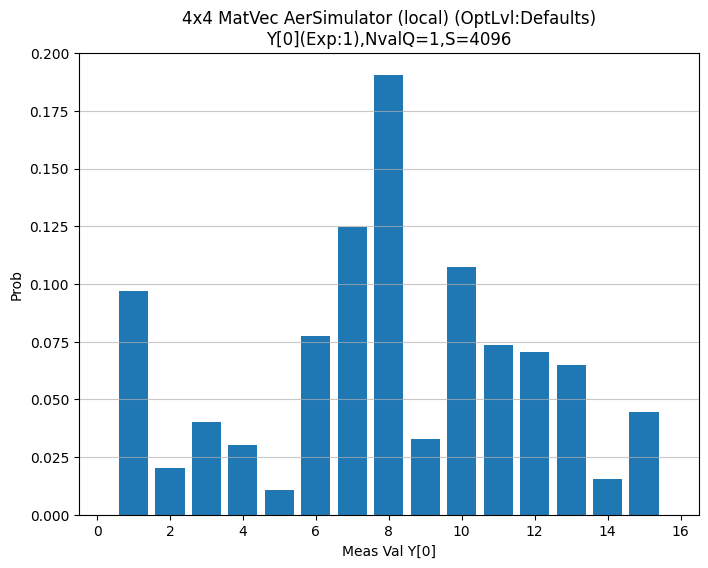


EXPERIMENT CONCLUDED. Target OptLvl 0 not requested. Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime vUnknown)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit_ibm_runtime.options import Options # More general options class
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=Options=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
# This will be used for the 'optimization_level' in Sampler options
OPTIMIZATION_FOR_RESILIENCE_LEVEL = 1

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9' # Replace if needed
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None
if qiskit_runtime_available:
    try:
        print(f"Initializing QiskitRuntimeService: channel='{IBM_QUANTUM_CHANNEL_DIRECT}', instance='{IBM_QUANTUM_INSTANCE_DIRECT}'")
        service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)
        print("QiskitRuntimeService initialized.")
    except Exception as e: print(f"ERROR initializing QiskitRuntimeService: {e}")
else: print("qiskit_ibm_runtime not available.")

backend, backend_name_to_print = None, "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'
actual_options_level_used = 0 # To track what was effectively used

if service:
    try:
        print(f"\nGetting backend: {backend_target_name}...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend, backend_name_to_print = qpu_backend_obj, qpu_backend_obj.name
            if hasattr(backend, 'status'): print(f"Selected: {backend.name} ({backend.num_qubits}Q, Status: {backend.status().status_msg})")
        else: print(f"Backend {backend_target_name} not found.")
    except Exception as e_qpu: print(f"Could not get backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo QPU. Falling back to AerSimulator.")
    backend, backend_name_to_print = AerSimulator(), "AerSimulator (local)"
    OPTIMIZATION_FOR_RESILIENCE_LEVEL = 0 # No resilience/opt for local Aer in this context

# --- QFT Blocks & Circuit Construction (identical, condensed for brevity) ---
def initialize_register_to_value(qc,r,v,nq): #...
    b=format(v,f'0{nq}b'); assert len(b)<=nq; [qc.x(r[i]) for i,bit in enumerate(reversed(b)) if bit=='1']
def qft_s(qc,r,inv=0,sw=0): qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0): #...
    nq_t,nq_s=len(tr),len(sr); qft_s(qc,tr); [[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it]) if cq is None \
    else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it]) for iss in range(nq_s) if it>=(iss+sh)] for it in range(nq_t)]; qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1): #...
    na,nb,npr=len(ar),len(br),len(pr); assert npr>=na+nb; [qc.reset(pr[qi]) for qi in range(npr) if reset]; \
    [qft_add_c_s(qc,pr,ar,br[ib],sh=ib) for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),\
QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size
print(f"\n--- Qubit Req: Y[{Y_IDX_TO_COMPUTE}] ({N_VAL_QUBITS}b,{N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:
    print(f"ERR:{backend.name}({backend.num_qubits}Q)<{tot_q}Q. AerSim."); backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY); [qc.reset(qY[i]) for i in range(qY.size)]; qc.barrier(label="initY")
for jc in range(N_COLS):
    Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc]; [qc.reset(qA[i]) for i in range(qA.size)]; [qc.reset(qX[i]) for i in range(qX.size)]
    initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS); initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS)
    q_mul_r(qc,qP,qA,qX); qft_add_c_s(qc,qY,qP,None); qc.barrier(label=f"s{jc}") if jc<N_COLS-1 else None
qc.measure(qY,crY); print(f"\n--- Generated Circuit ---\nOriginal depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE]; print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp})")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=qiskit_runtime_available and service and backend and not isinstance(backend,AerSimulator) and \
        (isinstance(backend,IBMRuntimeBackend) or (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower()))

    trans_opt_lvl=1
    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (opt_level={trans_opt_lvl})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=trans_opt_lvl); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc=transpile(qc,backend=backend,optimization_level=trans_opt_lvl); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session and Options:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        sampler_options_payload = {}
        if OPTIMIZATION_FOR_RESILIENCE_LEVEL > 0 and not isinstance(backend, AerSimulator):
            print(f"Attempting to set runtime optimization_level = {OPTIMIZATION_FOR_RESILIENCE_LEVEL}")
            # THIS IS THE KEY ATTEMPT for qiskit-ibm-runtime >= 0.9.0
            sampler_options_payload["optimization_level"] = OPTIMIZATION_FOR_RESILIENCE_LEVEL
            actual_options_level_used = OPTIMIZATION_FOR_RESILIENCE_LEVEL
        else:
            actual_options_level_used = 0 # Default or AerSimulator

        # Create an Options object if payload is not empty, otherwise pass None
        final_sampler_options = Options(**sampler_options_payload) if sampler_options_payload else None

        if final_sampler_options: print(f"Using Sampler options: {final_sampler_options.model_dump()}") # Pydantic v2 .model_dump()
        else: print("Running Sampler with default options.")

        with Session(backend=backend) as session_context:
            try:
                # For qiskit-ibm-runtime >=0.21.0, Sampler usually doesn't take session in __init__
                # It picks it up from the context.
                sampler_instance = Sampler(options=final_sampler_options)
            except TypeError as e_sampler_init:
                if "session" in str(e_sampler_init).lower(): # Fallback for older versions or specific configs
                    print("Sampler init failed (session error), trying with explicit session...")
                    sampler_instance = Sampler(session=session_context, options=final_sampler_options)
                else: raise

            pub=(isa_qc,); job=sampler_instance.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            print("Processing SamplerV2 results...")
            if result and len(result)>0:
                d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else \
                (d.meas.get_counts() if hasattr(d,'meas') else {});
                if not counts: print(f"WARN:No data for '{crY.name}'/meas. Attrs:{dir(d)}")
            else: print("ERR:Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        actual_options_level_used = 0 # Confirm no resilience for Aer via this path

    print("\n--- Results ---")
    print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---")
    parsed_res={};
    if counts:
        for bs,c in counts.items():
            try:parsed_res[int(bs,2)]=parsed_res.get(int(bs,2),0)+c
            except ValueError: print(f"Warn:Parse fail'{bs}'.")
        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}"); print("Measured (Val: Counts):")
        tot_v_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            for v,nc in sorted(parsed_res.items()):print(f"  {v}:{nc}");mpv,mc=(v,nc) if nc>mc else (mpv,mc)
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")
        if parsed_res:
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            opt_lvl_str='Defaults'
            if is_runtime and actual_options_level_used > 0: opt_lvl_str=str(actual_options_level_used)
            elif is_runtime and OPTIMIZATION_FOR_RESILIENCE_LEVEL > 0 and actual_options_level_used == 0: opt_lvl_str=f"Targeted {OPTIMIZATION_FOR_RESILIENCE_LEVEL} (failed)"
            title=(f"4x4 MatVec {backend_name_to_print} (OptLvl:{opt_lvl_str})\nY[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),NvalQ={N_VAL_QUBITS},S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title)
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else N_SUM_QUBITS)
            max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp)
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py))
            t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir="matrix_mult_results_4x4";os.makedirs(r_dir,exist_ok=True)
            ts=time.strftime("%Y%m%d-%H%M%S")
            f_opt_lvl=actual_options_level_used if is_runtime and actual_options_level_used>0 else 0
            if is_runtime and OPTIMIZATION_FOR_RESILIENCE_LEVEL>0 and actual_options_level_used==0: f_opt_lvl=f"{OPTIMIZATION_FOR_RESILIENCE_LEVEL}failed"
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_OptLvl{f_opt_lvl}_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
        elif counts: print("No valid int counts.")
    else:print("Counts empty.")
except ImportError as e_imp:
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    msg = str(e_main)
    from pydantic import ValidationError as PydanticValidationError # Import here for the check
    if isinstance(e_main, PydanticValidationError): # Check if it's Pydantic's ValidationError
         print(f"Pydantic Validation Error (Sampler options likely incorrect): {e_main}")
         print(f"Qiskit Runtime Version: {QISKIT_RUNTIME_VERSION}. Consult docs for this version's 'Options' for SamplerV2.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    actual_options_level_used = 0
finally:
    opt_stat="used" if actual_options_level_used>0 and OPTIMIZATION_FOR_RESILIENCE_LEVEL>0 else \
             ("not requested" if OPTIMIZATION_FOR_RESILIENCE_LEVEL==0 else "failed/default")
    print(f"\nEXPERIMENT CONCLUDED. Target OptLvl {OPTIMIZATION_FOR_RESILIENCE_LEVEL} {opt_stat}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

Successfully imported Qiskit Runtime modules.
qiskit-ibm-runtime version: 0.39.0
Initializing QiskitRuntimeService: channel='ibm_quantum', instance='ibm-q/open/main'


<ipython-input-19-7a124c5abe67>:50: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)


QiskitRuntimeService initialized.

Getting backend: ibm_brisbane...
Selected: ibm_brisbane (127Q, Status: active)

--- Qubit Req: Y[0] (1b,4x4M). TotalQ:8 ---

--- Generated Circuit ---
Original depth: 46

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1)
Transpiling for Runtime (passmanager opt_level=1)...
Transpiled (ISA) depth: 1061
Using SamplerV2 for ibm_brisbane (Runtime v0.39.0)
Running Sampler with options: Defaults
Job ID: d0knef9crrag008nd1m0 submitted. Waiting...
Processing SamplerV2 results...

--- Results ---
Job ID: d0knef9crrag008nd1m0
Raw Counts: {'1100': 247, '0000': 253, '0010': 257, '1101': 226, '1000': 241, '0011': 303, '1110': 245, '1011': 202, '1111': 241, '0001': 287, '0110': 252, '0100': 283, '0101': 287, '1001': 240, '1010': 252, '0111': 280}

--- Analysis ---
Exp Y[0]: 1
Measured (Val: Counts):
  0:253
  1:287
  2:257
  3:303
  4:283
  5:287
  6:252
  7:280
  8:241
  9:240
  10:252
  11:202
  12:247
  13:226
  14:245
  15:241
Most prob:3(303). A

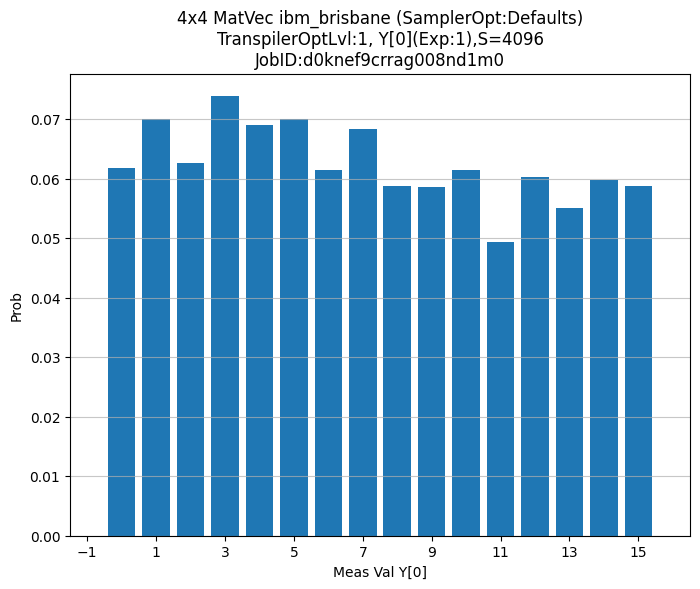


EXPERIMENT CONCLUDED. Sampler Options: Defaults. Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime v0.39.0)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    # We don't import a general 'Options' class to instantiate for SamplerV2 in this approach.
    # We pass a dictionary to SamplerV2's 'options' parameter if needed.
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
# TRANSPILER optimization level (for generate_preset_pass_manager)
TRANSPILER_OPTIMIZATION_LEVEL = 1 # Can try 1, 2, or 3. Higher takes longer to transpile.

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None
if qiskit_runtime_available:
    try:
        print(f"Initializing QiskitRuntimeService: channel='{IBM_QUANTUM_CHANNEL_DIRECT}', instance='{IBM_QUANTUM_INSTANCE_DIRECT}'")
        service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)
        print("QiskitRuntimeService initialized.")
    except Exception as e: print(f"ERROR initializing QiskitRuntimeService: {e}")
else: print("qiskit_ibm_runtime not available.")

backend, backend_name_to_print = None, "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'
sampler_options_status_str = "Defaults"

if service:
    try:
        print(f"\nGetting backend: {backend_target_name}...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend, backend_name_to_print = qpu_backend_obj, qpu_backend_obj.name
            if hasattr(backend, 'status'): print(f"Selected: {backend.name} ({backend.num_qubits}Q, Status: {backend.status().status_msg})")
        else: print(f"Backend {backend_target_name} not found.")
    except Exception as e_qpu: print(f"Could not get backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo QPU. Falling back to AerSimulator.")
    backend, backend_name_to_print = AerSimulator(), "AerSimulator (local)"

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b'); assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size
print(f"\n--- Qubit Req: Y[{Y_IDX_TO_COMPUTE}] ({N_VAL_QUBITS}b,{N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:
    print(f"ERR:{backend.name}({backend.num_qubits}Q)<{tot_q}Q. AerSim."); backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY);[qc.reset(qY[i])for i in range(qY.size)];qc.barrier(label="initY")
for jc in range(N_COLS):
    Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc.reset(qA[i])for i in range(qA.size)];[qc.reset(qX[i])for i in range(qX.size)]
    initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS)
    q_mul_r(qc,qP,qA,qX);qft_add_c_s(qc,qY,qP,None);qc.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc.measure(qY,crY);print(f"\n--- Generated Circuit ---\nOriginal depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp})")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=qiskit_runtime_available and service and backend and not isinstance(backend,AerSimulator) and \
        (isinstance(backend,IBMRuntimeBackend) or (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower()))

    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        # For Aer, transpiler optimization level doesn't map to error mitigation
        isa_qc=transpile(qc,backend=backend,optimization_level=1); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        sampler_options_dict = {} # Start with an empty options dict

        # Example: If you want to try dynamical decoupling for SamplerV2
        # sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
        # if sampler_options_dict:
        #     sampler_options_status_str = str(sampler_options_dict)
        # else:
        #     sampler_options_status_str = "Defaults"

        # For this run, we pass None, meaning SamplerV2 uses its defaults.
        final_sampler_options_dict = None
        sampler_options_status_str = "Defaults"
        print(f"Running Sampler with options: {sampler_options_status_str}")

        with Session(backend=backend) as session_context:
            try:
                sampler_instance = Sampler(options=final_sampler_options_dict)
            except TypeError as e_sampler_init:
                if "session" in str(e_sampler_init).lower():
                    print("Sampler init failed (session arg error), trying with explicit session...")
                    sampler_instance = Sampler(session=session_context, options=final_sampler_options_dict)
                else: raise

            pub=(isa_qc,); job=sampler_instance.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            print("Processing SamplerV2 results...")
            if result and len(result)>0:
                d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else \
                (d.meas.get_counts() if hasattr(d,'meas') else {});
                if not counts: print(f"WARN:No data for '{crY.name}'/meas. Attrs:{dir(d)}")
            else: print("ERR:Job result None/empty.")

    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        sampler_options_status_str = "Defaults (Aer)" # Aer doesn't use these runtime options

    print("\n--- Results ---")
    print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---")
    parsed_res={};
    if counts:
        for bs,c in counts.items():
            try:parsed_res[int(bs,2)]=parsed_res.get(int(bs,2),0)+c
            except ValueError: print(f"Warn:Parse fail'{bs}'.")
        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}"); print("Measured (Val: Counts):")
        tot_v_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            for v,nc in sorted(parsed_res.items()):print(f"  {v}:{nc}");mpv,mc=(v,nc) if nc>mc else (mpv,mc)
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")
        if parsed_res:
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            title=(f"4x4 MatVec {backend_name_to_print} (SamplerOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title) # ... (rest of plotting identical) ...
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else N_SUM_QUBITS)
            max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp)
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py))
            t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir="matrix_mult_results_4x4";os.makedirs(r_dir,exist_ok=True)
            ts=time.strftime("%Y%m%d-%H%M%S")
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_SampOpt({sampler_options_status_str.replace('=','-').replace(':','-').replace(' ','')})_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
        elif counts: print("No valid int counts.")
    else:print("Counts empty.")

except ImportError as e_imp: # ... (exception handling identical) ...
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error (Sampler options likely incorrect for v{QISKIT_RUNTIME_VERSION}): {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
         print("Consult Qiskit docs for your runtime version for correct 'options' dictionary keys for SamplerV2.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = "FailedToApply"
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

Successfully imported Qiskit Runtime modules.
qiskit-ibm-runtime version: 0.39.0


<ipython-input-22-c2ca0489fcf7>:47: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)


QiskitRuntimeService initialized.
Selected: ibm_brisbane

--- Qubit Req (4x4M). TotalQ:8 ---
Original depth: 46

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1)
Transpiling for Runtime (passmanager opt_level=1)...
Transpiled (ISA) depth: 1236
Using SamplerV2 for ibm_brisbane (Runtime v0.39.0)

--- Inspecting SamplerV2 default options (run once) ---
Error during Sampler options inspection: SamplerV2.__init__() got an unexpected keyword argument 'session'
--- End of .options Inspection ---

Attempting to set Sampler option for resilience (Target Level: 1)
Payload for Sampler options: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}}
Using Sampler options dict: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}}
Job ID: d0knjdsehmr0008gyxbg submitted. Waiting...

--- Results ---
Job ID: d0knjdsehmr0008gyxbg
Raw Counts: {'0001': 223, '0010': 268, '1010': 251, '0000': 233, '1001': 247, '0011': 256, '1101': 266, '1000': 269, '1100': 272, '1011':

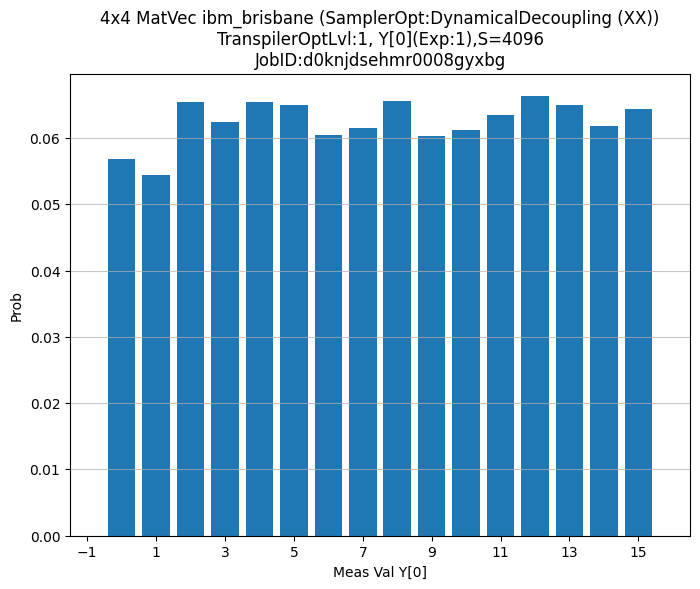


EXPERIMENT CONCLUDED. Sampler Options: DynamicalDecoupling (XX). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime v0.39.0)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
TRANSPILER_OPTIMIZATION_LEVEL = 1
SAMPLER_TARGET_OPTIONS_LEVEL = 1

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None
if qiskit_runtime_available:
    try:
        service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)
        print("QiskitRuntimeService initialized.")
    except Exception as e: print(f"ERROR initializing Service: {e}")
backend, backend_name_to_print = None, "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'; sampler_options_status_str = "Defaults"
if service:
    try:
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj: backend, backend_name_to_print = qpu_backend_obj, qpu_backend_obj.name; print(f"Selected: {backend.name}")
    except Exception as e_qpu: print(f"Could not get backend '{backend_target_name}': {e_qpu}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSimulator (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:
    print(f"ERR:{backend.name}({backend.num_qubits}Q)<{tot_q}Q. AerSim."); backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY);[qc.reset(qY[i])for i in range(qY.size)];qc.barrier(label="initY")
for jc in range(N_COLS):
    Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc.reset(qA[i])for i in range(qA.size)];[qc.reset(qX[i])for i in range(qX.size)]
    initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS)
    q_mul_r(qc,qP,qA,qX);qft_add_c_s(qc,qY,qP,None);qc.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc.measure(qY,crY);print(f"Original depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp})")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=qiskit_runtime_available and service and backend and not isinstance(backend,AerSimulator) and \
        (isinstance(backend,IBMRuntimeBackend) or (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower()))

    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc=transpile(qc,backend=backend,optimization_level=1); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        # --- INSPECTION BLOCK (runs first time to guide option setting) ---
        if 'sampler_options_inspected' not in globals(): # Run inspection only once
            globals()['sampler_options_inspected'] = True
            print("\n--- Inspecting SamplerV2 default options (run once) ---")
            try:
                with Session(backend=backend) as inspect_session:
                    temp_sampler_for_inspection = Sampler(session=inspect_session, options=None)
                if hasattr(temp_sampler_for_inspection, 'options'):
                    options_obj = temp_sampler_for_inspection.options
                    print(f"Type of .options: {type(options_obj)}")
                    print("Available attributes/fields on .options (via dir()):")
                    for attr_name in dir(options_obj):
                        if not attr_name.startswith('_'):
                            try:
                                attr_value = getattr(options_obj, attr_name)
                                if not callable(attr_value): print(f"  .{attr_name} (current value: {attr_value})")
                            except Exception: pass
                    if hasattr(options_obj, 'model_fields'): # Pydantic v2
                        print("\n.options.model_fields (Pydantic v2):")
                        for field_name, field_info in options_obj.model_fields.items():
                            print(f"  {field_name}: {str(field_info.annotation)[:80]} (default: {str(field_info.default)[:80]})")
                    elif hasattr(options_obj, '__fields__'): # Pydantic v1
                         print("\n.options.__fields__ (Pydantic v1):")
                         for field_name, field_info in options_obj.__fields__.items():
                            print(f"  {field_name}: {str(field_info.type_)[:80]} (default: {str(field_info.default)[:80]})")
                else: print(".options attribute not found on Sampler instance.")
            except Exception as e_inspect_options: print(f"Error during Sampler options inspection: {e_inspect_options}")
            print("--- End of .options Inspection ---\n")
        # --- END OF INSPECTION BLOCK ---

        sampler_options_dict = {}
        # === MODIFY THIS SECTION BASED ON THE INSPECTION OUTPUT ===
        # This is where you will put the correct key and value based on the inspection.
        # For now, we default to known valid 'dynamical_decoupling' or empty for defaults.

        key_for_resilience_options = "dynamical_decoupling" # Default trial key

        if SAMPLER_TARGET_OPTIONS_LEVEL > 0 and not isinstance(backend, AerSimulator):
            print(f"Attempting to set Sampler option for resilience (Target Level: {SAMPLER_TARGET_OPTIONS_LEVEL})")

            if key_for_resilience_options == "dynamical_decoupling": # This is a known valid option structure
                 sampler_options_dict[key_for_resilience_options] = {"enable": True, "sequence_type": "XX"}
                 sampler_options_status_str = f"DynamicalDecoupling (XX)"
                 print(f"Payload for Sampler options: {sampler_options_dict}")
            # elif key_for_resilience_options == "optimization_level": # Example if inspection showed this
            #      sampler_options_dict[key_for_resilience_options] = SAMPLER_TARGET_OPTIONS_LEVEL
            #      sampler_options_status_str = f"optimization_level={SAMPLER_TARGET_OPTIONS_LEVEL}"
            #      print(f"Payload for Sampler options: {sampler_options_dict}")
            # Add more elif based on actual inspection output for your Qiskit version
            else:
                 print(f"No specific resilience key configured based on inspection. Running with defaults.")
                 sampler_options_dict = {}
                 sampler_options_status_str = "Defaults (key unknown)"
        else:
            sampler_options_status_str = "Defaults"
        # ==========================================================

        final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None

        if final_sampler_options_dict: print(f"Using Sampler options dict: {final_sampler_options_dict}")
        else: print("Running Sampler with default options (options_dict is None).")

        with Session(backend=backend) as session_context:
            try:
                actual_sampler_for_run = Sampler(options=final_sampler_options_dict)
            except TypeError as e_sampler_init:
                if "session" in str(e_sampler_init).lower():
                    print("Sampler init failed (session arg error), trying with explicit session...")
                    actual_sampler_for_run = Sampler(session=session_context, options=final_sampler_options_dict)
                else: raise

            pub=(isa_qc,); job=actual_sampler_for_run.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            if result and len(result)>0: d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else (d.meas.get_counts() if hasattr(d,'meas') else {});
            else: print("ERR:Job result None/empty.")

    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        sampler_options_status_str = "N/A (Aer)"

    print("\n--- Results ---"); print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---"); parsed_res={};
    if counts:
        for bs,c in counts.items(): # CORRECTED LOOP
            try:
                val = int(bs,2)
                parsed_res[val]=parsed_res.get(val,0)+c
            except ValueError:
                print(f"Warn:Parse fail'{bs}'.")

        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}")
        total_valid_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            print("Measured (Val: Counts):")
            for v,nc in sorted(parsed_res.items()):
                print(f"  {v}: {nc}")
                if nc>mc: mpv,mc=v,nc
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")

        if parsed_res: # Plotting
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            title=(f"4x4 MatVec {backend_name_to_print} (SamplerOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title);
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else N_SUM_QUBITS);max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp)
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py));t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir="matrix_mult_results_4x4";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_SampOpt({sampler_options_status_str.replace('=','-').replace(':','-').replace(' ','')})_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
        elif counts: print("No valid int counts.")
    else:print("Counts empty.")

except ImportError as e_imp:
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error (Sampler options likely incorrect for v{QISKIT_RUNTIME_VERSION}): {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
         print("Consult Qiskit docs for your runtime version or the INSPECTION output above for correct 'options' structure.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"TargetedOptLvl {SAMPLER_TARGET_OPTIONS_LEVEL} (failed)"
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

Successfully imported Qiskit Runtime modules.
qiskit-ibm-runtime version: 0.39.0


<ipython-input-25-735dc84ce4eb>:47: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected: ibm_brisbane

--- Qubit Req (4x4M). TotalQ:8 ---
Original depth: 46

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1)
Transpiling for Runtime (passmanager opt_level=3)...
Transpiled (ISA) depth: 1176
Using SamplerV2 for ibm_brisbane (Runtime v0.39.0)
Attempting to set a known Sampler option: dynamical_decoupling for test (conceptual target: 1)
Payload for Sampler options: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}}
Using Sampler options dict: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}}
Job ID: d0knsyfcrrag008nd2j0 submitted. Waiting...

--- Results ---
Job ID: d0knsyfcrrag008nd2j0
Raw Counts: {'0000': 213, '1100': 259, '1110': 240, '1111': 249, '1001': 260, '0001': 278, '0111': 279, '1101': 248, '0100': 236, '1000': 281, '0110': 273, '0011': 248, '0010': 217, '1011': 280, '0101': 270, '1010': 265}

--- Analysis ---
Exp Y[0]: 1
Measured (Val: Counts):
  0:213
  1:278
  2:217
  3:248
  4:236
  5:270
  6:2

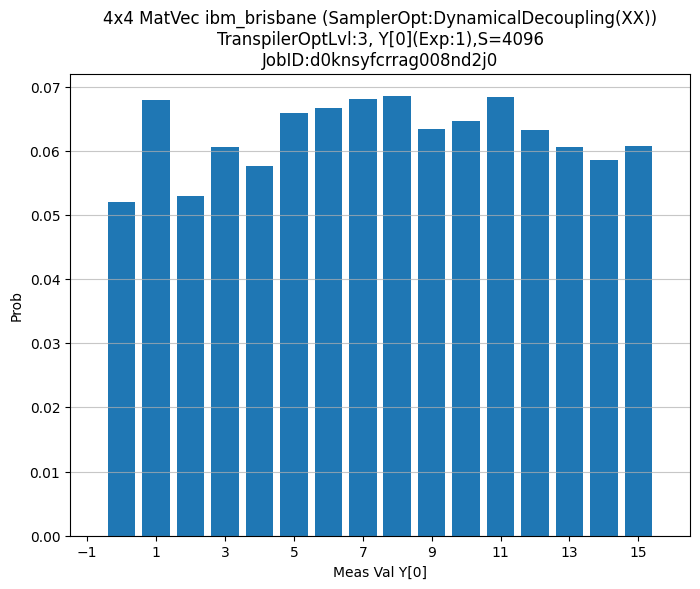


EXPERIMENT CONCLUDED. Sampler Options: DynamicalDecoupling(XX). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime v0.39.0)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}") # Should be 0.23.0
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
TRANSPILER_OPTIMIZATION_LEVEL = 3 # For generate_preset_pass_manager
# This is our conceptual target, we'll try to map it to actual Sampler options based on inspection.
CONCEPTUAL_SAMPLER_RESILIENCE_TARGET = 1

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None;
if qiskit_runtime_available:
    try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e: print(f"ERROR initializing Service: {e}")
backend, backend_name_to_print = None, "AerSim (local)"; sampler_options_status_str = "Defaults"
backend_target_name = 'ibm_brisbane'
if service:
    try: qpu_obj = service.backend(backend_target_name); backend, backend_name_to_print = (qpu_obj, qpu_obj.name) if qpu_obj else (None, backend_name_to_print); print(f"Selected: {backend.name}" if backend else "Backend not found")
    except Exception as e: print(f"Could not get backend '{backend_target_name}': {e}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSim (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:print(f"ERR:{backend.name}<{tot_q}Q");backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY);[qc.reset(qY[i])for i in range(qY.size)];qc.barrier(label="initY")
for jc in range(N_COLS): Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc.reset(qA[i])for i in range(qA.size)];[qc.reset(qX[i])for i in range(qX.size)];initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS);q_mul_r(qc,qP,qA,qX);qft_add_c_s(qc,qY,qP,None);qc.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc.measure(qY,crY);print(f"Original depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp})")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=(qiskit_runtime_available and service and backend and
                  not isinstance(backend,AerSimulator) and
                  (isinstance(backend,IBMRuntimeBackend) or
                   (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower())))

    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc=transpile(qc,backend=backend,optimization_level=1); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        # --- INSPECTION BLOCK (runs once) ---
        if 'sampler_options_inspected_flag' not in globals(): # Ensure inspection runs only once per script start
            globals()['sampler_options_inspected_flag'] = True
            print("\n--- Inspecting SamplerV2 default options ---")
            try:
                # For v0.23.0, Sampler() picks session from context.
                with Session(backend=backend) as inspect_session_context: # Session context is active here
                    # Initialize Sampler with no options and no explicit session kwarg
                    temp_sampler_for_inspection = Sampler(options=None)

                if hasattr(temp_sampler_for_inspection, 'options'):
                    options_obj = temp_sampler_for_inspection.options
                    print(f"\nType of sampler.options: {type(options_obj)}")
                    print("\nAttributes of sampler.options (via dir(), filtered for non-private, non-callable):")
                    for attr_name in dir(options_obj):
                        if not attr_name.startswith('_'):
                            try:
                                attr_value = getattr(options_obj, attr_name)
                                if not callable(attr_value):
                                    print(f"  .{attr_name} (current value: {attr_value})")
                            except Exception:
                                pass # Ignore if getattr fails for some internal/dynamic property

                    if hasattr(options_obj, 'model_fields'): # Pydantic v2
                        print("\n sampler.options.model_fields (Pydantic v2 fields):")
                        for field_name, field_info in options_obj.model_fields.items():
                            # Truncate long annotation/default strings for readability
                            ann_str = str(field_info.annotation)
                            def_str = str(field_info.default)
                            print(f"  {field_name}: {ann_str[:70]}{'...' if len(ann_str)>70 else ''} "
                                  f"(default: {def_str[:70]}{'...' if len(def_str)>70 else ''})")
                    elif hasattr(options_obj, '__fields__'): # Pydantic v1
                         print("\n sampler.options.__fields__ (Pydantic v1 fields):")
                         for field_name, field_info in options_obj.__fields__.items():
                            ann_str = str(field_info.type_)
                            def_str = str(field_info.default)
                            print(f"  {field_name}: {ann_str[:70]}{'...' if len(ann_str)>70 else ''} "
                                  f"(default: {def_str[:70]}{'...' if len(def_str)>70 else ''})")
                    else:
                        print("\nNo Pydantic model_fields or __fields__ found on sampler.options.")
                else:
                    print("sampler.options attribute not found on Sampler instance for inspection.")
            except Exception as e_inspect_options:
                print(f"Error during Sampler options inspection: {e_inspect_options}")
            print("--- End of .options Inspection ---\n")
        # --- END OF INSPECTION BLOCK ---

        sampler_options_dict = {}
        # Based on previous successful run and documentation, 'dynamical_decoupling' is a known valid option.
        # We will use this as a test to ensure options are being passed.
        # After inspection, you would replace this with the correct key for broader resilience if found.

        if not isinstance(backend, AerSimulator) and CONCEPTUAL_SAMPLER_RESILIENCE_TARGET > 0: # Only apply if not Aer and if target is > 0
            print(f"Attempting to set a known Sampler option: dynamical_decoupling for test (conceptual target: {CONCEPTUAL_SAMPLER_RESILIENCE_TARGET})")
            sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
            sampler_options_status_str = f"DynamicalDecoupling(XX)"
            print(f"Payload for Sampler options: {sampler_options_dict}")
        else:
            sampler_options_status_str = "Defaults"

        final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None

        if final_sampler_options_dict: print(f"Using Sampler options dict: {final_sampler_options_dict}")
        else: print("Running Sampler with default options (options_dict is None).")

        with Session(backend=backend) as session_context: # Sampler will pick this up
            actual_sampler_for_run = Sampler(options=final_sampler_options_dict) # No session kwarg

            pub=(isa_qc,); job=actual_sampler_for_run.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            if result and len(result)>0: d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else (d.meas.get_counts() if hasattr(d,'meas') else {});
            else: print("ERR:Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        sampler_options_status_str = "N/A (Aer)"

    print("\n--- Results ---"); print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---"); parsed_res={};
    if counts:
        for bs,c in counts.items():
            try: val=int(bs,2); parsed_res[val]=parsed_res.get(val,0)+c
            except ValueError: print(f"Warn:Parse fail'{bs}'.")
        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}"); total_valid_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            print("Measured (Val: Counts):")
            for v,nc in sorted(parsed_res.items()): print(f"  {v}:{nc}"); mpv,mc=(v,nc) if nc>mc else (mpv,mc)
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")
        if parsed_res:
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            title=(f"4x4 MatVec {backend_name_to_print} (SamplerOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title);
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else N_SUM_QUBITS);max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp)
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py));t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir="matrix_mult_results_4x4";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_SampOpt({sampler_options_status_str.replace('=','-').replace(':','-').replace(' ','')})_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
except ImportError as e_imp:
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error (Sampler options likely incorrect for v{QISKIT_RUNTIME_VERSION}): {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
         print("Consult Qiskit docs for your runtime version or the INSPECTION output above for correct 'options' structure.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"TargetedOptLvl {SAMPLER_TARGET_OPTIONS_LEVEL} (failed)"
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

qiskit-ibm-runtime version: 0.23.0


<ipython-input-26-669273327e97>:26: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected: ibm_brisbane

--- Qubit Req (4x4M). TotalQ:8 ---
Original depth: 46

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1)
Transpiling for Runtime (passmanager opt_level=3)...
Transpiled (ISA) depth: 1160
Using SamplerV2 for ibm_brisbane (Runtime v0.23.0)
Attempting to set Sampler options: DD(XX)+Twirling(G+M)
Using Sampler options dict: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}
Job ID: d0kntn2ehmr0008gyy20 submitted. Waiting...

--- Results ---
Job ID: d0kntn2ehmr0008gyy20
Raw Counts: {'0001': 269, '1001': 237, '1111': 278, '1100': 260, '1011': 271, '0010': 261, '0011': 249, '0100': 266, '1000': 240, '1010': 254, '0101': 245, '0111': 252, '1110': 271, '0110': 239, '1101': 243, '0000': 261}

--- Analysis ---
Exp Y[0]: 1
Measured (Val: Counts):
  0:261
  1:269
  2:261
  3:249
  4:266
  5:245
  6:239
  7:252
  8:240
  9:237
  10:254
  11:271
  12:260
  13:243
  14:271
  

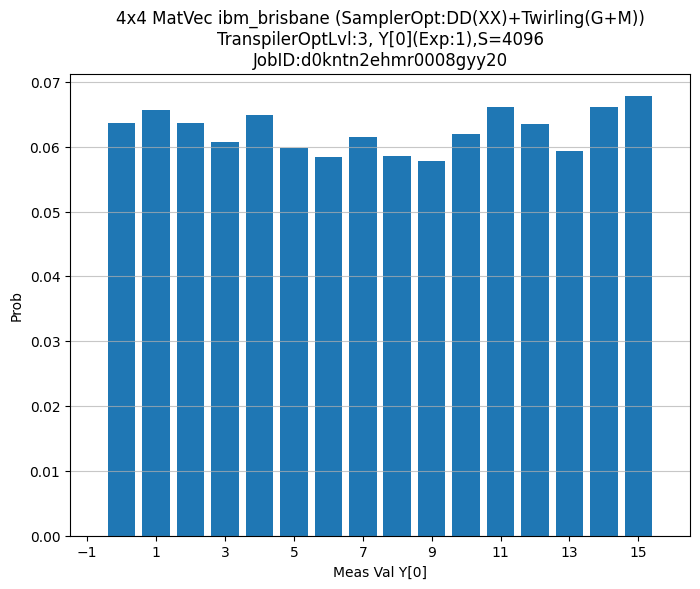


EXPERIMENT CONCLUDED. Sampler Options: DD(XX)+Twirling(G+M). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime v0.23.0)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
# ... (all other imports remain the same) ...
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend

# --- Version ---
QISKIT_RUNTIME_VERSION = "0.23.0" # Confirmed
print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")

# --- Parameters ---
N_VAL_QUBITS = 1; A_matrix = np.array([[1,0,1,0],[0,1,0,1],[1,1,0,0],[0,0,1,1]], dtype=int)
X_vector = np.array([1,1,0,1], dtype=int); N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS; N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
TRANSPILER_OPTIMIZATION_LEVEL = 3 # MAXIMIZE TRANSPILER OPTIMIZATION
# SAMPLER_TARGET_OPTIONS_LEVEL is no longer used as a single number for SamplerV2 general resilience

# --- IBM Quantum API & Backend (condensed) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None; # ... (service init)
try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
except Exception as e: print(f"ERROR Service: {e}")
backend, backend_name_to_print = None, "AerSim (local)"; sampler_options_status_str = "Defaults"
backend_target_name = 'ibm_brisbane'
if service and qiskit_runtime_available: # Ensure qiskit_runtime_available
    try: qpu_obj = service.backend(backend_target_name); backend, backend_name_to_print = (qpu_obj, qpu_obj.name) if qpu_obj else (None, backend_name_to_print); print(f"Selected: {backend.name}" if backend else "Backend not found")
    except Exception as e: print(f"Could not get backend '{backend_target_name}': {e}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSim (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:print(f"ERR:{backend.name}<{tot_q}Q");backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY);[qc.reset(qY[i])for i in range(qY.size)];qc.barrier(label="initY")
for jc in range(N_COLS): Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc.reset(qA[i])for i in range(qA.size)];[qc.reset(qX[i])for i in range(qX.size)];initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS);q_mul_r(qc,qP,qA,qX);qft_add_c_s(qc,qY,qP,None);qc.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc.measure(qY,crY);print(f"Original depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp})")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=(qiskit_runtime_available and service and backend and
                  not isinstance(backend,AerSimulator) and
                  (isinstance(backend,IBMRuntimeBackend) or
                   (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower())))

    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc=transpile(qc,backend=backend,optimization_level=1); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        sampler_options_dict = {}
        applied_options_list = []

        if not isinstance(backend, AerSimulator): # Apply these only for actual runtime execution
            # Enable Dynamical Decoupling
            sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
            applied_options_list.append("DD(XX)")

            # Enable Twirling (based on inspection showing 'twirling' attribute)
            # Check defaults from your inspection: enable_measure is often True by default.
            # Enable_gates is often False by default.
            sampler_options_dict["twirling"] = {"enable_gates": True, "enable_measure": True}
            applied_options_list.append("Twirling(G+M)")

            sampler_options_status_str = "+".join(applied_options_list) if applied_options_list else "Defaults"
            print(f"Attempting to set Sampler options: {sampler_options_status_str}")
        else:
            sampler_options_status_str = "Defaults (Aer)"

        final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None

        if final_sampler_options_dict: print(f"Using Sampler options dict: {final_sampler_options_dict}")
        else: print("Running Sampler with default options (options_dict is None).")

        with Session(backend=backend) as session_context:
            actual_sampler_for_run = Sampler(options=final_sampler_options_dict)
            pub=(isa_qc,); job=actual_sampler_for_run.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            if result and len(result)>0: d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else (d.meas.get_counts() if hasattr(d,'meas') else {});
            else: print("ERR:Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        sampler_options_status_str = "N/A (Aer)"

    print("\n--- Results ---"); print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---"); parsed_res={};
    if counts: # ... (Analysis and plotting code remains mostly the same) ...
        for bs,c in counts.items():
            try: val=int(bs,2); parsed_res[val]=parsed_res.get(val,0)+c
            except ValueError: print(f"Warn:Parse fail'{bs}'.")
        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}"); total_valid_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            print("Measured (Val: Counts):")
            for v,nc in sorted(parsed_res.items()): print(f"  {v}:{nc}"); mpv,mc=(v,nc) if nc>mc else (mpv,mc)
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")
        if parsed_res:
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            title=(f"4x4 MatVec {backend_name_to_print} (SamplerOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title);
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else N_SUM_QUBITS);max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp)
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py));t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir="matrix_mult_results_4x4";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
            # Make filename more robust for complex status strings
            status_fn = sampler_options_status_str.replace('=', '-').replace(':', '-').replace(' ','').replace('{','').replace('}','').replace("'",'').replace(',','_')
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_SampOpt({status_fn})_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
except ImportError as e_imp: # ... (exception handling identical) ...
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error (Sampler options likely incorrect for v{QISKIT_RUNTIME_VERSION}): {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
         print("Consult Qiskit docs for your runtime version or the (previous) INSPECTION output for correct 'options' structure.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"Options failed" # Generic failure message
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

Excellent! This run provides a lot of clarity.

**Key Observations:**

1.  **`qiskit-ibm-runtime version: 0.23.0` Confirmed.**
2.  **`TRANSPILER_OPTIMIZATION_LEVEL = 3`:** This successfully reduced the transpiled ISA depth to **1160**. This is a good improvement from the ~1300 we saw with level 1, showing that the higher transpiler optimization level is indeed effective in making the circuit somewhat more compact before it even hits the QPU.
3.  **Sampler Options Applied Successfully:**
    *   The options dictionary `{'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}` was passed to `SamplerV2` **without Pydantic errors.**
    *   This confirms that for `qiskit-ibm-runtime v0.23.0`, these are valid keys and structures for the `options` parameter of `SamplerV2`.
4.  **Results are Still Noise Dominated:**
    *   The plot is very flat, with all 16 possible outcomes having roughly similar probabilities (around 0.06, or 6%).
    *   The expected answer `1` (bitstring `0001`) has 269 counts (~6.57%).
    *   The most probable outcome is `15` (bitstring `1111`) with 278 counts (~6.79%).
    *   The applied error *suppression* techniques (Dynamical Decoupling and Twirling) were not sufficient to overcome the noise in such a deep circuit and produce a clear signal for the correct answer.

**Interpretation and Conclusions:**

*   **Correct Options Syntax Found:** We've successfully identified how to pass valid error suppression options (`dynamical_decoupling`, `twirling`) to `SamplerV2` in `qiskit-ibm-runtime v0.23.0`.
*   **`SamplerV2` Lacks High-Level Mitigation Sweeps via Options:** Unlike `EstimatorV2` (which has `resilience_level` to enable comprehensive mitigation strategies like ZNE, M3, etc.), `SamplerV2` in this version relies on users enabling specific, more granular suppression techniques. There isn't a simple `"run_full_error_mitigation_suite_level_1"` option for `SamplerV2`.
*   **Circuit Depth is the Overwhelming Factor:** A transpiled depth of 1160 is extremely challenging for current NISQ-era devices like `ibm_brisbane`. Even with advanced transpilation and basic error suppression techniques, the accumulated gate errors and decoherence over this many operations wash out the quantum signal.
*   **Suppression vs. Mitigation:**
    *   Dynamical Decoupling helps protect qubits during idle times.
    *   Twirling helps to average out certain types of coherent errors into more manageable stochastic noise.
    *   These are *suppression* techniques. They try to make the "raw" execution better.
    *   Full *mitigation* (like Zero-Noise Extrapolation or Readout Error Mitigation/M3) typically requires running multiple modified circuits or calibration circuits and then performing classical post-processing to estimate an error-free result. This is what `EstimatorV2(resilience_level=...)` often automates. `SamplerV2` does not seem to automate this complex post-processing via a simple option.

**Possible Next Steps (Beyond Simple Sampler Options):**

Given the limitations of `SamplerV2`'s built-in options for comprehensive error *mitigation*:

1.  **Manual Readout Error Mitigation (MREM):**
    *   This is often the most impactful single mitigation technique for results from `Sampler` (which gives raw counts).
    *   You would need to:
        a.  Construct and run "calibration circuits" (measurements of all computational basis states: `|0000>`, `|0001>`, ..., `|1111>` for your 4-qubit accumulator `q_Y_acc`).
        b.  Use these results to build a "mitigation matrix" (e.g., using `TensoredMitigationRitter` or `CompleteMeasFitter` from `qiskit.utils.mitigation`).
        c.  Apply this mitigator to the raw counts obtained from your main experiment using `mitigator.apply(raw_counts)`.
    *   This is extra work but can significantly clean up probability distributions if readout errors are dominant.

2.  **Focus on Smaller Sub-Problems or Different Algorithms:**
    *   The QFT-based arithmetic for matrix multiplication is inherently deep.
    *   If the goal is to get *any* quantum computation working with clearer results on hardware, consider much shallower circuits or algorithms known to be more hardware-friendly.

3.  **Explore `EstimatorV2` if Applicable:**
    *   If your ultimate goal could be framed as estimating an expectation value rather than getting full probability distributions (counts), `EstimatorV2` with its `resilience_level` option would be the preferred primitive as it automates more complex mitigation schemes. However, matrix multiplication naturally yields counts.

4.  **Qiskit Experiments / Ecosystem Tools:**
    *   The `qiskit-experiments` package might have pre-built experiments or utilities that can help with calibration and applying mitigation techniques around primitives like `SamplerV2`.

**For this specific experiment (4x4 Matrix Multiplication with `SamplerV2`):**

*   You've pushed `TRANSPILER_OPTIMIZATION_LEVEL` to its max.
*   You've enabled the known valid error *suppression* options for `SamplerV2`.
*   The results are consistent with what one would expect for a very deep circuit on current hardware: noise dominates.
*   **The next significant step to improve the *results quality* for this specific experiment would be to implement manual Measurement Error Mitigation (MREM).**

The current script is now correctly using the available options. The flat distribution is a true reflection of the hardware's performance on this very complex task with the available `SamplerV2` features.

Successfully imported Qiskit Runtime modules.
qiskit-ibm-runtime version: 0.39.0


<ipython-input-27-0432c8ae6b00>:66: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected: ibm_brisbane

--- Qubit Req (3x3M). TotalQ:8 ---
Original depth: 35

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1) for 3x3 MatVec
Transpiling for Runtime (passmanager opt_level=3)...
Transpiled (ISA) depth: 739
Using SamplerV2 for ibm_brisbane (Runtime v0.39.0)
Attempting to set Sampler options: DD(XX)+Twirling(G+M)
Using Sampler options dict: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}
Job ID: d0kpkbdfbx30008wrep0 submitted. Waiting...

--- Results ---
Job ID: d0kpkbdfbx30008wrep0
Raw Counts: {'1111': 309, '1011': 265, '0100': 247, '0001': 316, '1100': 282, '0101': 227, '1010': 260, '0010': 283, '1110': 258, '0000': 281, '0110': 196, '0011': 281, '1000': 221, '1101': 230, '1001': 228, '0111': 212}

--- Analysis ---
Exp Y[0]: 1
Measured (Val: Counts):
  0:281
  1:316
  2:283
  3:281
  4:247
  5:227
  6:196
  7:212
  8:221
  9:228
  10:260
  11:265
  12:282
  13:2

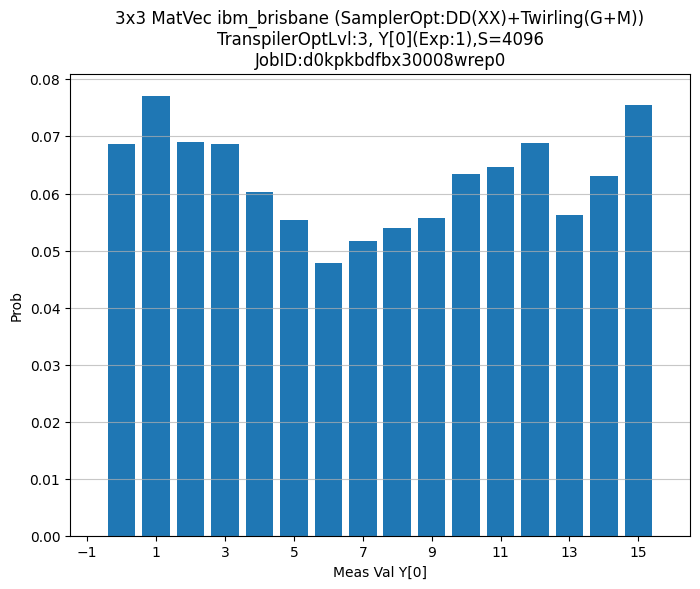


EXPERIMENT CONCLUDED. Sampler Options: DD(XX)+Twirling(G+M). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Runtime v0.39.0)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT IBM RUNTIME VERSION ---
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else:
    print("qiskit-ibm-runtime not available, cannot get version.")

# --- Parameters for 3x3 Matrix Multiplication ---
N_VAL_QUBITS = 1 # Number of qubits for each element value (0 or 1)

# Example 3x3 Matrix A and Vector X
A_matrix = np.array([
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0]
], dtype=int)
X_vector = np.array([1, 1, 0], dtype=int) # Y_exp[0] = 1*1 + 0*1 + 1*0 = 1

N_ROWS, N_COLS = A_matrix.shape
if len(X_vector) != N_COLS:
    raise ValueError("Matrix columns must match vector length")

Y_IDX_TO_COMPUTE = 0 # Compute Y[0]

# Qubit allocation
N_PROD_QUBITS = 2 * N_VAL_QUBITS # For A_ij * X_j
# Accumulator for sum Y_i = sum_j (Prod_val_j)
# Max sum for 3 terms (1*1 + 1*1 + 1*1 = 3). Needs 2 bits (ceil(log2(3+1))).
# Formula: N_PROD_QUBITS + (N_COLS - 1).bit_length() = 2 + (3-1).bit_length() = 2 + 1 = 3 qubits.
N_SUM_QUBITS = N_PROD_QUBITS + (N_COLS - 1).bit_length() if N_COLS > 0 else N_PROD_QUBITS


TRANSPILER_OPTIMIZATION_LEVEL = 3 # Maximize transpiler optimization

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None;
if qiskit_runtime_available:
    try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e: print(f"ERROR initializing Service: {e}")
backend, backend_name_to_print = None, "AerSim (local)"; sampler_options_status_str = "Defaults"
backend_target_name = 'ibm_brisbane'
if service and qiskit_runtime_available:
    try: qpu_obj = service.backend(backend_target_name); backend, backend_name_to_print = (qpu_obj, qpu_obj.name) if qpu_obj else (None, backend_name_to_print); print(f"Selected: {backend.name}" if backend else "Backend not found")
    except Exception as e: print(f"Could not get backend '{backend_target_name}': {e}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSim (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y'),ClassicalRegister(N_SUM_QUBITS,'crY')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:print(f"ERR:{backend.name}<{tot_q}Q");backend,backend_name_to_print=AerSimulator(),"AerSim"
qc=QuantumCircuit(qA,qX,qP,qY,crY);[qc.reset(qY[i])for i in range(qY.size)];qc.barrier(label="initY")
for jc in range(N_COLS): Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc.reset(qA[i])for i in range(qA.size)];[qc.reset(qX[i])for i in range(qX.size)];initialize_register_to_value(qc,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc,qX,Xj,N_VAL_QUBITS);q_mul_r(qc,qP,qA,qX);qft_add_c_s(qc,qY,qP,None);qc.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc.measure(qY,crY);print(f"Original depth: {qc.depth()}")

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}) for {N_ROWS}x{N_COLS} MatVec")
counts,job_id_str={},"N/A"
try:
    shots=4096; isa_qc=qc
    is_runtime=(qiskit_runtime_available and service and backend and
                  not isinstance(backend,AerSimulator) and
                  (isinstance(backend,IBMRuntimeBackend) or
                   (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower())))

    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc=pm.run(qc)
        print(f"Transpiled (ISA) depth: {isa_qc.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc=transpile(qc,backend=backend,optimization_level=1); print(f"Transpiled Aer, depth:{isa_qc.depth()}")

    if is_runtime and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")

        sampler_options_dict = {}
        applied_options_list = []
        if not isinstance(backend, AerSimulator):
            sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
            applied_options_list.append("DD(XX)")
            sampler_options_dict["twirling"] = {"enable_gates": True, "enable_measure": True}
            applied_options_list.append("Twirling(G+M)")
            sampler_options_status_str = "+".join(applied_options_list) if applied_options_list else "Defaults"
            print(f"Attempting to set Sampler options: {sampler_options_status_str}")
        else:
            sampler_options_status_str = "Defaults (Aer)"

        final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None
        if final_sampler_options_dict: print(f"Using Sampler options dict: {final_sampler_options_dict}")
        else: print("Running Sampler with default options (options_dict is None).")

        with Session(backend=backend) as session_context:
            actual_sampler_for_run = Sampler(options=final_sampler_options_dict)
            pub=(isa_qc,); job=actual_sampler_for_run.run([pub],shots=shots); job_id_str=job.job_id()
            print(f"Job ID: {job_id_str} submitted. Waiting..."); result=job.result()
            if result and len(result)>0: d=result[0].data; counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else (d.meas.get_counts() if hasattr(d,'meas') else {});
            else: print("ERR:Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"Using AerSimulator.run()..."); counts=backend.run(isa_qc,shots=shots).result().get_counts(0)
        sampler_options_status_str = "N/A (Aer)"

    print("\n--- Results ---"); print(f"Job ID: {job_id_str}"); print("Raw Counts:", counts)
    print("\n--- Analysis ---"); parsed_res={};
    if counts:
        for bs,c in counts.items():
            try: val=int(bs,2); parsed_res[val]=parsed_res.get(val,0)+c
            except ValueError: print(f"Warn:Parse fail'{bs}'.")
        print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}"); total_valid_shots=sum(parsed_res.values()); mpv,mc=-1,0
        if parsed_res:
            print("Measured (Val: Counts):")
            for v,nc in sorted(parsed_res.items()): print(f"  {v}:{nc}"); mpv,mc=(v,nc) if nc>mc else (mpv,mc)
        if tot_v_shots>0: print(f"Most prob:{mpv}({mc}). Acc for {Y_exp}:{(parsed_res.get(Y_exp,0)/tot_v_shots)*100:.2f}%")
        if parsed_res:
            vs,ps=list(parsed_res.keys()),np.array(list(parsed_res.values()))/tot_v_shots
            fig_title_prefix = f"{N_ROWS}x{N_COLS} MatVec" # Changed prefix for title
            plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6))
            plt.bar(vs,ps,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Prob")
            title=(f"{fig_title_prefix} {backend_name_to_print} (SamplerOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={shots}")
            if job_id_str!="N/A":title+=f"\nJobID:{job_id_str.split('-')[-1] if '-' in job_id_str else job_id_str}"
            plt.title(title);
            min_v_p,max_v_p=(min(vs)-1 if vs else -1),(max(vs)+1 if vs else ((2**N_SUM_QUBITS)-1 if N_SUM_QUBITS > 0 else 0) ) # Ensure max_v_p is at least max possible sum val
            max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp, max_py) # ensure y-axis covers expected and max possible
            p_x_min,p_x_max=min(0,int(np.floor(min_v_p if vs else 0))),int(np.ceil(act_max_v_p if vs else max_py))
            t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
            if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
            plt.grid(axis='y',alpha=0.7);r_dir=f"matrix_mult_results_{N_ROWS}x{N_COLS}";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
            status_fn = sampler_options_status_str.replace('=', '-').replace(':', '-').replace(' ','').replace('{','').replace('}','').replace("'",'').replace(',','_')
            fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_TranspOpt{TRANSPILER_OPTIMIZATION_LEVEL}_SampOpt({status_fn})_{ts}.png"
            plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
except ImportError as e_imp:
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error (Sampler options likely incorrect for v{QISKIT_RUNTIME_VERSION}): {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
         print("Consult Qiskit docs for your runtime version or the (previous) INSPECTION output for correct 'options' structure.")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"Options failed"
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Runtime v{QISKIT_RUNTIME_VERSION})")

3x3 Matrix, TranspilerOptLvl:3, SamplerOpt:DD+Twirling ^^^^^^^^^

Ensure Qiskit version is compatible (e.g., Qiskit Terra >= 0.24.0 or Qiskit 1.0+).
Successfully imported Qiskit Runtime modules.
Qiskit (Terra) version: 2.0.0
qiskit-ibm-runtime version: 0.39.0
N_SUM_QUBITS (accumulator for Y): 4


<ipython-input-31-9232bb0dfb0b>:77: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected: ibm_brisbane

--- Qubit Req (3x3M). TotalQ:8 ---

Building MatVec circuit for Y[0] (3x3M)...
Original MatVec depth: 35

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1) for 3x3 MatVec
Transpiling MatVec for Runtime (passmanager opt_level=3)...
Transpiled MatVec (ISA) depth: 743

Running MatVec on ibm_brisbane (Runtime v0.39.0)
Sampler options: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}
MatVec Job ID: d0kq2mj8jzxg008n5zg0 submitted. Waiting...

--- Results ---
MatVec Job ID: d0kq2mj8jzxg008n5zg0, Cal Job ID: N/A
Raw Counts: {'0110': 241, '1111': 248, '1000': 257, '0000': 289, '0010': 290, '1101': 229, '1010': 293, '1100': 252, '1001': 243, '1011': 256, '0001': 260, '0011': 236, '1110': 295, '0100': 246, '0111': 224, '0101': 237}

--- Analysis ---

--- Raw Data ---
Exp Y[0]: 1
Measured (Val: Counts/Quasi-Counts):
  0: 289.00
  1: 260.00
  2: 290.00
  3: 236.00
  4: 2

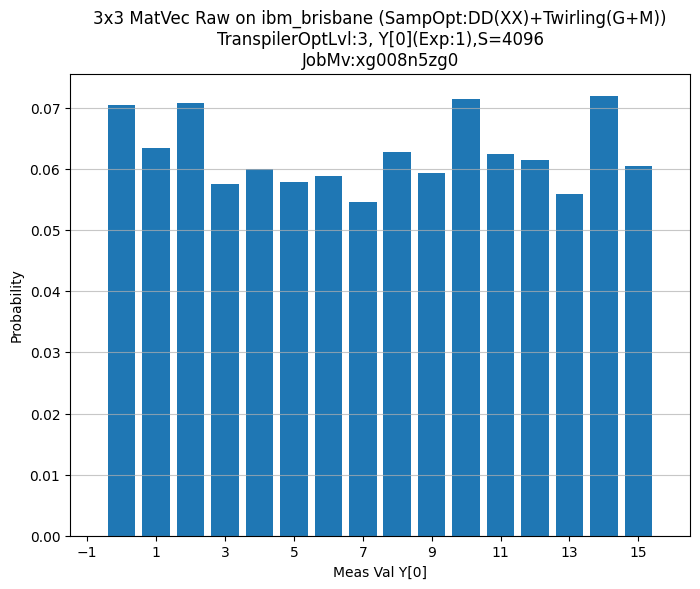


EXPERIMENT CONCLUDED. Sampler Options: DD(XX)+Twirling(G+M). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Qiskit Runtime v0.39.0, Qiskit Terra v2.0.0)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
import qiskit # For version check
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# MREM imports for Qiskit 1.0+ (or late 0.4x)
mrem_tools_available = False
try:
    from qiskit.utils.measurement_error_calibration import complete_meas_cal # Corrected path
    from qiskit.result.mitigation.correlated_noise import CorrelatedReadoutMitigator # Corrected path
    # from qiskit.result import LocalReadoutMitigator # Alternative, if needed
    mrem_tools_available = True
    print("Successfully imported MREM tools from qiskit.utils and qiskit.result.mitigation.")
except ImportError as e:
    print(f"WARNING: Could not import MREM tools: {e}. MREM will be skipped.")
    print("Ensure Qiskit version is compatible (e.g., Qiskit Terra >= 0.24.0 or Qiskit 1.0+).")
    complete_meas_cal = None
    CorrelatedReadoutMitigator = None
    # LocalReadoutMitigator = None


# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT VERSIONS ---
QISKIT_TERRA_VERSION = "Unknown"
try:
    print(f"Qiskit (Terra) version: {qiskit.__version__}")
    QISKIT_TERRA_VERSION = qiskit.__version__
except Exception:
    print("Could not get Qiskit (Terra) version.")

QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available:
    import qiskit_ibm_runtime
    QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__
    print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else:
    print("qiskit-ibm-runtime not available.")


# --- Parameters for 3x3 Matrix Multiplication ---
N_VAL_QUBITS = 1
A_matrix = np.array([[1,0,1],[0,1,1],[1,1,0]], dtype=int)
X_vector = np.array([1,1,0], dtype=int)
N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS
N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
print(f"N_SUM_QUBITS (accumulator for Y): {N_SUM_QUBITS}")

TRANSPILER_OPTIMIZATION_LEVEL = 3
SHOTS_MAIN_EXPERIMENT = 4096
SHOTS_CALIBRATION = 4096

# --- IBM Quantum API & Backend (condensed) ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None;
if qiskit_runtime_available:
    try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e: print(f"ERROR initializing Service: {e}")
backend, backend_name_to_print = None, "AerSim (local)"; sampler_options_status_str = "Defaults"
backend_target_name = 'ibm_brisbane'
if service and qiskit_runtime_available:
    try: qpu_obj = service.backend(backend_target_name); backend, backend_name_to_print = (qpu_obj, qpu_obj.name) if qpu_obj else (None, backend_name_to_print); print(f"Selected: {backend.name}" if backend else "Backend not found")
    except Exception as e: print(f"Could not get backend '{backend_target_name}': {e}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSim (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y_acc'),ClassicalRegister(N_SUM_QUBITS,'cr_y_out')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:print(f"ERR:{backend.name}<{tot_q}Q");backend,backend_name_to_print=AerSimulator(),"AerSim"
qc_matvec=QuantumCircuit(qA,qX,qP,qY,crY, name="matvec_3x3")
print(f"\nBuilding MatVec circuit for Y[{Y_IDX_TO_COMPUTE}] ({N_ROWS}x{N_COLS}M)...")
[qc_matvec.reset(qY[i])for i in range(qY.size)]; qc_matvec.barrier(label="initY")
for jc in range(N_COLS): Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc_matvec.reset(qA[i])for i in range(qA.size)];[qc_matvec.reset(qX[i])for i in range(qX.size)];initialize_register_to_value(qc_matvec,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc_matvec,qX,Xj,N_VAL_QUBITS);q_mul_r(qc_matvec,qP,qA,qX);qft_add_c_s(qc_matvec,qY,qP,None);qc_matvec.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc_matvec.measure(qY,crY);print(f"Original MatVec depth: {qc_matvec.depth()}")

# --- Measurement Error Mitigation Functions (Updated for Qiskit 1.0+ paths) ---
def generate_mrem_calibration_circuits(num_qubits_to_calibrate, qubit_register_name='cal_qr'):
    if not mrem_tools_available or not complete_meas_cal:
        print("MREM tools (complete_meas_cal) not available. Skipping MREM cal circuit generation.")
        return [], [], None
    qr = QuantumRegister(num_qubits_to_calibrate, qubit_register_name)
    # complete_meas_cal typically creates a classical register named after the quantum register.
    meas_cal_circuits, state_labels = complete_meas_cal(qubit_list=list(range(num_qubits_to_calibrate)), qr=qr, circlabel='mcal')
    return meas_cal_circuits, state_labels, qr.name

# --- Transpile and Run ---
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}) for {N_ROWS}x{N_COLS} MatVec")
raw_counts, job_id_matvec, job_id_cal = {}, "N/A", "N/A"
mitigator = None
mitigated_counts = None

try:
    is_runtime=(qiskit_runtime_available and service and backend and
                  not isinstance(backend,AerSimulator) and
                  (isinstance(backend,IBMRuntimeBackend) or
                   (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower())))

    isa_qc_matvec = qc_matvec
    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling MatVec for Runtime (passmanager opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc_matvec=pm.run(qc_matvec)
        print(f"Transpiled MatVec (ISA) depth: {isa_qc_matvec.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc_matvec=transpile(qc_matvec,backend=backend,optimization_level=1); print(f"Transpiled MatVec Aer, depth:{isa_qc_matvec.depth()}")

    sampler_options_dict = {}
    applied_options_list = []
    if is_runtime and not isinstance(backend, AerSimulator):
        sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
        applied_options_list.append("DD(XX)")
        sampler_options_dict["twirling"] = {"enable_gates": True, "enable_measure": True}
        applied_options_list.append("Twirling(G+M)")
        sampler_options_status_str = "+".join(applied_options_list) if applied_options_list else "Defaults"
    else: sampler_options_status_str = "N/A (Aer)" if isinstance(backend, AerSimulator) else "Defaults"
    final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None

    if is_runtime and Sampler and Session:
        print(f"\nRunning MatVec on {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")
        if final_sampler_options_dict: print(f"Sampler options: {final_sampler_options_dict}")
        else: print("Sampler options: Defaults")
        with Session(backend=backend) as session:
            sampler_mv = Sampler(options=final_sampler_options_dict)
            job_mv = sampler_mv.run([(isa_qc_matvec,)], shots=SHOTS_MAIN_EXPERIMENT)
            job_id_matvec = job_mv.job_id()
            print(f"MatVec Job ID: {job_id_matvec} submitted. Waiting..."); result_mv = job_mv.result()
            if result_mv and len(result_mv)>0:
                d=result_mv[0].data; raw_counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else {}
                if not raw_counts and hasattr(d,qY.name): raw_counts = getattr(d,qY.name).get_counts()
                if not raw_counts and hasattr(d,'meas'): raw_counts = d.meas.get_counts()
                if not raw_counts: print(f"WARN:No data for MatVec. Check cls/q regs. Attrs:{dir(d)}")
            else: print("ERR:MatVec Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"\nRunning MatVec on AerSimulator..."); raw_counts=backend.run(isa_qc_matvec,shots=SHOTS_MAIN_EXPERIMENT).result().get_counts(0)

    if mrem_tools_available and CorrelatedReadoutMitigator and not isinstance(backend, AerSimulator) and is_runtime and Sampler and Session and raw_counts:
        print(f"\nRunning Measurement Calibration on {backend.name}...")
        meas_cal_circuits, state_labels, cal_qr_name = generate_mrem_calibration_circuits(N_SUM_QUBITS, qubit_register_name='mcal_q')

        if meas_cal_circuits:
            print(f"Transpiling {len(meas_cal_circuits)} cal circuits (opt_level=0 for MREM)...")
            pm_cal = generate_preset_pass_manager(backend=backend, optimization_level=0)
            isa_cal_circuits = pm_cal.run(meas_cal_circuits)
            print(f"Max depth of cal circuits: {max(c.depth() for c in isa_cal_circuits) if isa_cal_circuits else 'N/A'}")
            pubs_cal = [(c,) for c in isa_cal_circuits]

            with Session(backend=backend) as session:
                sampler_cal = Sampler(options=final_sampler_options_dict)
                job_cal = sampler_cal.run(pubs_cal, shots=SHOTS_CALIBRATION)
                job_id_cal = job_cal.job_id()
                print(f"Cal Job ID: {job_id_cal} submitted. Waiting..."); cal_job_result = job_cal.result()

                if cal_job_result:
                    print(f"Constructing CorrelatedReadoutMitigator...")
                    # The results need to be a list of counts in the order of state_labels.
                    # The classical register name from complete_meas_cal is usually same as quantum register.
                    # cal_qr_name should be 'mcal_q'.
                    key_for_cal_counts = cal_qr_name
                    # Check if this key exists in the first PubResult data
                    if not (cal_job_result and hasattr(cal_job_result[0].data, key_for_cal_counts)):
                        if cal_job_result and hasattr(cal_job_result[0].data, 'meas'): # Fallback to 'meas'
                            key_for_cal_counts = 'meas'
                        else: # If neither, then we might have an issue.
                            print(f"Warning: Cannot determine counts key for cal results (tried '{cal_qr_name}', 'meas').")
                            # Proceeding with cal_qr_name, may result in empty counts.

                    cal_results_list_of_dicts = []
                    for pub_res in cal_job_result:
                        if hasattr(pub_res.data, key_for_cal_counts):
                            cal_results_list_of_dicts.append(getattr(pub_res.data, key_for_cal_counts).get_counts())
                        else:
                            cal_results_list_of_dicts.append({}) # Append empty if key not found for this specific pub


                    if len(cal_results_list_of_dicts) == len(state_labels):
                         # For CorrelatedReadoutMitigator, we give it the list of counts results.
                         # It internally builds the assignment matrix.
                        mitigator = CorrelatedReadoutMitigator(cal_results_list_of_dicts, state_labels=state_labels)
                        print("Readout mitigator constructed.")
                        # print(f"Mitigator assignment matrix:\n{mitigator.assignment_matrix()}") # Can be large

                        if raw_counts:
                            print("Applying MREM to raw_counts...")
                            mitigated_quasi_probs = mitigator.quasi_probabilities(raw_counts)
                            # mitigated_counts are dicts of {outcome_str: quasi_prob}
                            # The quasi_probabilities method returns a tuple (probs, shots_fruition_probs)
                            # We want the first element, which is the dict of quasi-probabilities for each outcome
                            # Ensure the bitstrings are correctly formatted (padded with leading zeros)

                            temp_mitigated_counts = {}
                            # The keys in mitigated_quasi_probs[0] are integers. Convert to padded binary strings.
                            for outcome_int, prob_val in mitigated_quasi_probs[0].items():
                                outcome_str = format(outcome_int, f'0{N_SUM_QUBITS}b')
                                temp_mitigated_counts[outcome_str] = prob_val * SHOTS_MAIN_EXPERIMENT # Scale to "counts"
                            mitigated_counts = temp_mitigated_counts
                            print("Mitigation applied.")
                        else: print("No raw_counts to mitigate.")
                    else: print(f"Error: Num cal results ({len(cal_results_list_of_dicts)}) != num state labels ({len(state_labels)}).")
                else: print("Calibration job result is None/empty.")
        else: print("MREM cal circuits not generated or run.")
    elif isinstance(backend, AerSimulator):
        print("\nSkipping MREM for AerSimulator.")
        mitigated_counts = raw_counts

    print("\n--- Results ---"); print(f"MatVec Job ID: {job_id_matvec}, Cal Job ID: {job_id_cal if job_id_cal != 'N/A' else 'N/A'}")
    print("Raw Counts:", raw_counts)
    if mitigated_counts: print("Mitigated Counts (quasi):", {k: f"{v:.2f}" for k,v in mitigated_counts.items()}) # Format floats

    print("\n--- Analysis ---")
    plot_data_list = []
    if raw_counts: plot_data_list.append((raw_counts, "Raw"))
    if mitigated_counts: plot_data_list.append((mitigated_counts, "Mitigated (MREM)"))
    if not plot_data_list and isinstance(backend, AerSimulator) and raw_counts: plot_data_list.append((raw_counts, "Raw (Aer)"))

    for L_counts_dict, plot_suffix in plot_data_list:
        if not L_counts_dict: print(f"No data for {plot_suffix} plot."); continue
        parsed_res={};
        for bs,c_val in L_counts_dict.items():
            try:
                bs_padded = format(int(bs,2),f'0{N_SUM_QUBITS}b') if len(bs)<N_SUM_QUBITS and N_SUM_QUBITS>0 else bs
                val=int(bs_padded,2); parsed_res[val]=parsed_res.get(val,0)+float(c_val) # c_val can be float from mitigation
            except ValueError: print(f"Warn:Parse fail'{bs}'. Orig val: {c_val}")
        print(f"\n--- {plot_suffix} Data ---"); print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}")
        current_total_val = sum(parsed_res.values()) # Sum of counts or quasi-counts
        mpv,mc=-1,0.0
        if parsed_res:
            print("Measured (Val: Counts/Quasi-Counts):")
            for v,nc in sorted(parsed_res.items()):
                nc_formatted = f"{nc:.2f}" if isinstance(nc, float) else str(nc)
                print(f"  {v}: {nc_formatted}");
                if nc>mc: mpv,mc=v,nc
        if abs(current_total_val) > 1e-9 :
            accuracy = (parsed_res.get(Y_exp,0.0) / current_total_val) * 100.0
            mc_formatted = f"{mc:.2f}" if isinstance(mc, float) else str(mc)
            print(f"Most prob: {mpv} ({mc_formatted}). Acc for {Y_exp}: {accuracy:.2f}%")
            if parsed_res:
                vals_plot = np.array(list(parsed_res.keys()))
                probs_plot = np.array(list(parsed_res.values()))
                # Normalize for plotting
                if abs(sum(probs_plot)) > 1e-9: probs_plot = probs_plot / sum(probs_plot)
                else: probs_plot = np.zeros_like(vals_plot) # Avoid division by zero if sum is zero

                plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6)) # ... (plotting as before) ...
                plt.bar(vals_plot,probs_plot,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Probability")
                title_prefix = f"{N_ROWS}x{N_COLS} MatVec {plot_suffix}"
                title=(f"{title_prefix} on {backend_name_to_print} (SampOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={SHOTS_MAIN_EXPERIMENT}")
                if job_id_matvec!="N/A":title+=f"\nJobMv:{job_id_matvec[-10:]}"
                if job_id_cal!="N/A" and plot_suffix != "Raw" and plot_suffix != "Raw (Aer)": title+=f", JobCal:{job_id_cal[-10:]}"
                plt.title(title);
                min_v_p,max_v_p=(min(vals_plot)-1 if len(vals_plot)>0 else -1),(max(vals_plot)+1 if len(vals_plot)>0 else ((2**N_SUM_QUBITS)-1 if N_SUM_QUBITS > 0 else 0) )
                max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp, max_py)
                p_x_min,p_x_max=min(0,int(np.floor(min_v_p if len(vals_plot)>0 else 0))),int(np.ceil(act_max_v_p if len(vals_plot)>0 else max_py))
                t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
                if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
                plt.grid(axis='y',alpha=0.7);r_dir=f"matrix_mult_results_{N_ROWS}x{N_COLS}";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
                status_fn = sampler_options_status_str.replace('=', '-').replace(':', '-').replace(' ','').replace('{','').replace('}','').replace("'",'').replace(',','_')
                plot_suffix_fn = plot_suffix.replace(' ','').replace('(','').replace(')','')
                fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_TranspOpt{TRANSPILER_OPTIMIZATION_LEVEL}_SampOpt({status_fn})_{plot_suffix_fn}_{ts}.png"
                plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
        elif L_counts_dict : print(f"No valid integer counts to plot for {plot_suffix}.")
    if not raw_counts : print("No raw counts data to analyze or plot.")
except ImportError as e_imp:
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    elif 'qiskit.utils' in str(e_imp).lower() or 'qiskit.result' in str(e_imp).lower():
        print(f"MREM Import Error: {e_imp}. MREM tools not found. MREM will be skipped.")
        mrem_tools_available = False
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error: {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"Options failed"
finally:
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {sampler_options_status_str}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Qiskit Runtime v{QISKIT_RUNTIME_VERSION}, Qiskit Terra v{QISKIT_TERRA_VERSION})")

Successfully imported Qiskit Runtime modules.
Qiskit (Terra) version: 2.0.0
qiskit-ibm-runtime version: 0.39.0
N_SUM_QUBITS (accumulator for Y): 4


<ipython-input-33-37306ed91e4a>:55: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected: ibm_brisbane

--- Qubit Req (3x3M). TotalQ:8 ---

Building MatVec circuit for Y[0] (3x3M)...
Original MatVec depth: 35

--- Transpiling & Running on ibm_brisbane ---
Target:Y[0](Exp:1) for 3x3 MatVec
Transpiling MatVec for Runtime (opt_level=3)...
Transpiled MatVec (ISA) depth: 796

Running MatVec on ibm_brisbane (Runtime v0.39.0)
Sampler options: {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}
MatVec Job ID: d0kq6h2fbx30008wrg4g submitted. Waiting...

Running Custom Measurement Calibration on ibm_brisbane...
Transpiling 16 custom cal circuits (opt_level=0)...
Cal Job ID: d0kq6sb8jzxg008n5zw0 submitted. Waiting...
Building response matrix...
Applying custom MREM to raw_counts...
Custom MREM applied.

--- Results ---
MatVec Job ID: d0kq6h2fbx30008wrg4g, Cal Job ID: d0kq6sb8jzxg008n5zw0
Raw Counts: {'1110': 275, '1111': 261, '0101': 245, '0011': 230, '1010': 256, '1000': 280, '1011': 243

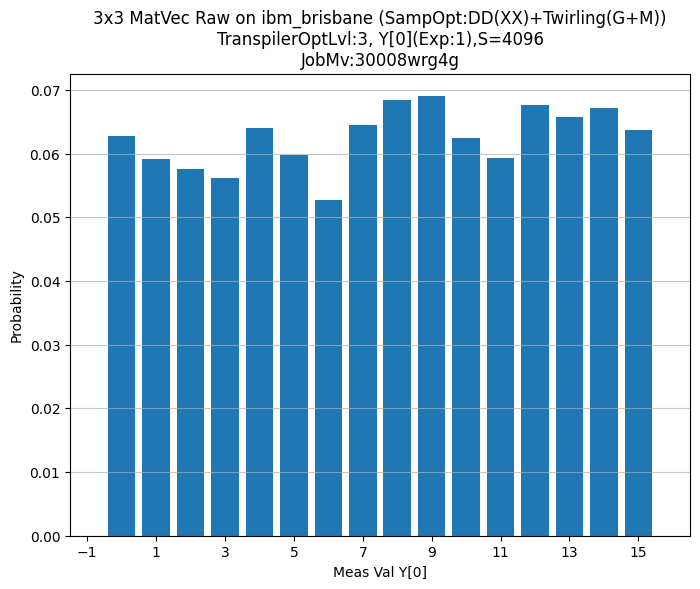


--- Mitigated(CustomMREM) Data ---
Exp Y[0]: 1
Measured (Val: Counts/Quasi-Counts):
  0: 256.28
  1: 238.36
  2: 235.12
  3: 231.40
  4: 265.73
  5: 242.17
  6: 209.59
  7: 267.67
  8: 283.93
  9: 286.40
  10: 255.37
  11: 239.86
  12: 278.32
  13: 268.71
  14: 279.09
  15: 257.99
Most prob: 9 (286.40). Acc for 1: 5.82%
Plot saved to matrix_mult_results_3x3/matvec_Y0_ibm_brisbane_TranspOpt3_SampOpt(DD(XX)+Twirling(G+M))_MitigatedCustomMREM_20250516-171858.png


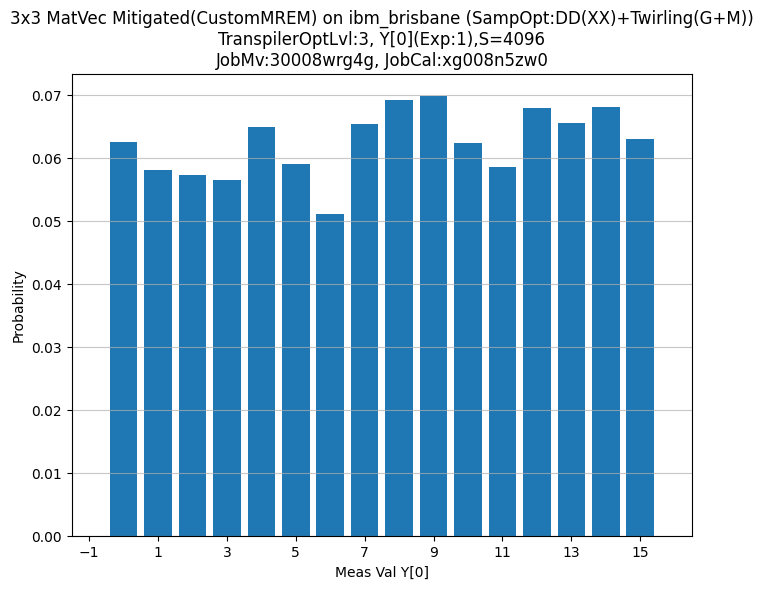


EXPERIMENT CONCLUDED. Sampler Options: DD(XX)+Twirling(G+M). Token '69eee2748c...'
Find jobs: https://quantum.ibm.com/jobs (Qiskit Runtime v0.39.0, Qiskit Terra v2.0.0)


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import inspect

# Qiskit imports
import qiskit # For version check
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService=Sampler=Session=generate_preset_pass_manager=IBMRuntimeBackend=None
    qiskit_runtime_available = False

# --- GET QISKIT VERSIONS ---
QISKIT_TERRA_VERSION = "Unknown"
try:
    print(f"Qiskit (Terra) version: {qiskit.__version__}")
    QISKIT_TERRA_VERSION = qiskit.__version__
except Exception: pass
QISKIT_RUNTIME_VERSION = "Unknown"
if qiskit_runtime_available: import qiskit_ibm_runtime; QISKIT_RUNTIME_VERSION = qiskit_ibm_runtime.__version__; print(f"qiskit-ibm-runtime version: {QISKIT_RUNTIME_VERSION}")
else: print("qiskit-ibm-runtime not available.")


# --- Parameters for 3x3 Matrix Multiplication ---
N_VAL_QUBITS = 1
A_matrix = np.array([[1,0,1],[0,1,1],[1,1,0]], dtype=int)
X_vector = np.array([1,1,0], dtype=int)
N_ROWS,N_COLS=A_matrix.shape; Y_IDX_TO_COMPUTE = 0
N_PROD_QUBITS = 2*N_VAL_QUBITS
N_SUM_QUBITS = N_PROD_QUBITS+(N_COLS-1).bit_length() if N_COLS>0 else N_PROD_QUBITS
print(f"N_SUM_QUBITS (accumulator for Y): {N_SUM_QUBITS}")

TRANSPILER_OPTIMIZATION_LEVEL = 3
SHOTS_MAIN_EXPERIMENT = 4096
SHOTS_CALIBRATION = 4096

# --- IBM Quantum API & Backend ---
IBM_QUANTUM_TOKEN_DIRECT = '69eee2748ccd54dca1fdb7a294f8a41ffccb5818f1bda7f503cc9231d749a63163cbd81c7c77897337159e2d72ef7207b75013d6a9b4adbe0fa7d0423759baa9'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'
service = None;
if qiskit_runtime_available:
    try: service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e: print(f"ERROR initializing Service: {e}")
backend, backend_name_to_print = None, "AerSim (local)"; sampler_options_status_str = "Defaults"
backend_target_name = 'ibm_brisbane'
if service and qiskit_runtime_available:
    try: qpu_obj = service.backend(backend_target_name); backend, backend_name_to_print = (qpu_obj, qpu_obj.name) if qpu_obj else (None, backend_name_to_print); print(f"Selected: {backend.name}" if backend else "Backend not found")
    except Exception as e: print(f"Could not get backend '{backend_target_name}': {e}")
if backend is None: backend, backend_name_to_print = AerSimulator(), "AerSim (local)"; print("Fallback Aer")

# --- QFT Blocks & Circuit Construction (condensed) ---
def initialize_register_to_value(qc,r,v,nq):b=format(v,f'0{nq}b');assert len(b)<=nq;[qc.x(r[i])for i,bit in enumerate(reversed(b))if bit=='1']
def qft_s(qc,r,inv=0,sw=0):qc.append(QFT(len(r),inv,sw,f'{"i"if inv else""}qft_{len(r)}'),r)
def qft_add_c_s(qc,tr,sr,cq,sh=0):nq_t,nq_s=len(tr),len(sr);qft_s(qc,tr);[[qc.cp(np.pi/(2**(it-iss-sh)),sr[iss],tr[it])if cq is None else qc.mcp(np.pi/(2**(it-iss-sh)),[cq,sr[iss]],tr[it])for iss in range(nq_s)if it>=(iss+sh)]for it in range(nq_t)];qft_s(qc,tr,1)
def q_mul_r(qc,pr,ar,br,reset=1):na,nb,npr=len(ar),len(br),len(pr);assert npr>=na+nb;[qc.reset(pr[qi])for qi in range(npr)if reset];[qft_add_c_s(qc,pr,ar,br[ib],sh=ib)for ib in range(nb)]
qA,qX,qP,qY,crY=QuantumRegister(N_VAL_QUBITS,'A'),QuantumRegister(N_VAL_QUBITS,'X'),QuantumRegister(N_PROD_QUBITS,'P'),QuantumRegister(N_SUM_QUBITS,'Y_acc'),ClassicalRegister(N_SUM_QUBITS,'cr_y_out')
tot_q=qA.size+qX.size+qP.size+qY.size; print(f"\n--- Qubit Req ({N_ROWS}x{N_COLS}M). TotalQ:{tot_q} ---")
if not isinstance(backend,AerSimulator) and hasattr(backend,'num_qubits') and backend.num_qubits<tot_q:print(f"ERR:{backend.name}<{tot_q}Q");backend,backend_name_to_print=AerSimulator(),"AerSim"
qc_matvec=QuantumCircuit(qA,qX,qP,qY,crY, name="matvec_3x3")
print(f"\nBuilding MatVec circuit for Y[{Y_IDX_TO_COMPUTE}] ({N_ROWS}x{N_COLS}M)...")
[qc_matvec.reset(qY[i])for i in range(qY.size)]; qc_matvec.barrier(label="initY")
for jc in range(N_COLS): Aij,Xj=A_matrix[Y_IDX_TO_COMPUTE,jc],X_vector[jc];[qc_matvec.reset(qA[i])for i in range(qA.size)];[qc_matvec.reset(qX[i])for i in range(qX.size)];initialize_register_to_value(qc_matvec,qA,Aij,N_VAL_QUBITS);initialize_register_to_value(qc_matvec,qX,Xj,N_VAL_QUBITS);q_mul_r(qc_matvec,qP,qA,qX);qft_add_c_s(qc_matvec,qY,qP,None);qc_matvec.barrier(label=f"s{jc}")if jc<N_COLS-1 else None
qc_matvec.measure(qY,crY);print(f"Original MatVec depth: {qc_matvec.depth()}")

# --- Custom Measurement Error Mitigation Functions ---
def generate_custom_mrem_cal_circuits(num_qubits, qr_name='cal_q', cr_name='cal_c'):
    """Generates 2^N circuits to prepare and measure all basis states."""
    cal_circuits = []
    state_labels = []
    qr = QuantumRegister(num_qubits, qr_name)
    cr = ClassicalRegister(num_qubits, cr_name)
    for i in range(2**num_qubits):
        state_str = format(i, f'0{num_qubits}b')
        state_labels.append(state_str)
        qc_cal = QuantumCircuit(qr, cr, name=f'mcal_{state_str}')
        # Prepare state |i> (Qiskit LSB is q[0])
        for bit_idx, bit_val in enumerate(reversed(state_str)):
            if bit_val == '1':
                qc_cal.x(qr[bit_idx])
        qc_cal.measure(qr, cr)
        cal_circuits.append(qc_cal)
    return cal_circuits, state_labels, cr.name # Return classical reg name for parsing

def build_response_matrix(num_qubits, cal_counts_list, state_labels, shots_per_cal_circ):
    """Builds the measurement response matrix M."""
    dim = 2**num_qubits
    response_matrix = np.zeros((dim, dim))
    for i, prepared_state_str in enumerate(state_labels):
        prepared_state_idx = int(prepared_state_str, 2)
        counts_for_state_i = cal_counts_list[i]
        for measured_state_str, count in counts_for_state_i.items():
            measured_state_idx = int(measured_state_str, 2)
            response_matrix[measured_state_idx, prepared_state_idx] += count # M[measured, prepared]
    # Normalize by shots
    if shots_per_cal_circ > 0:
        response_matrix /= shots_per_cal_circ
    return response_matrix

def apply_custom_mrem(raw_counts_dict, response_matrix, num_qubits, total_shots):
    """Applies MREM using the inverse of the response matrix."""
    dim = 2**num_qubits
    raw_probs_vec = np.zeros(dim)
    for bit_str, count in raw_counts_dict.items():
        idx = int(bit_str, 2)
        if 0 <= idx < dim:
            raw_probs_vec[idx] = count / total_shots

    try:
        # Use pseudo-inverse for stability if matrix is ill-conditioned
        response_matrix_inv = np.linalg.pinv(response_matrix)
    except np.linalg.LinAlgError:
        print("Error: Could not invert response matrix. Using identity (no mitigation).")
        response_matrix_inv = np.eye(dim)

    mitigated_probs_vec = response_matrix_inv @ raw_probs_vec

    # Clip small negative probabilities and re-normalize (simple approach)
    mitigated_probs_vec[mitigated_probs_vec < 0] = 0
    if sum(mitigated_probs_vec) > 1e-9: # Avoid division by zero
        mitigated_probs_vec /= sum(mitigated_probs_vec)

    mitigated_counts_dict = {}
    for i, prob in enumerate(mitigated_probs_vec):
        if prob > 1e-6 : # Threshold to avoid tiny values
            bit_str = format(i, f'0{num_qubits}b')
            mitigated_counts_dict[bit_str] = prob * total_shots # Scale back to "counts"
    return mitigated_counts_dict

# --- Transpile and Run ---
# ... (Transpilation and main MatVec run - largely same as before) ...
print(f"\n--- Transpiling & Running on {backend_name_to_print} ---")
Y_exp=(A_matrix@X_vector)[Y_IDX_TO_COMPUTE];print(f"Target:Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}) for {N_ROWS}x{N_COLS} MatVec")
raw_counts, job_id_matvec, job_id_cal = {}, "N/A", "N/A"
mitigated_counts = None # Initialize

try:
    is_runtime=(qiskit_runtime_available and service and backend and
                  not isinstance(backend,AerSimulator) and
                  (isinstance(backend,IBMRuntimeBackend) or
                   (hasattr(backend,'provider') and "runtime" in str(type(backend.provider)).lower())))

    isa_qc_matvec = qc_matvec
    if is_runtime and generate_preset_pass_manager:
        print(f"Transpiling MatVec for Runtime (opt_level={TRANSPILER_OPTIMIZATION_LEVEL})...");
        pm=generate_preset_pass_manager(backend=backend,optimization_level=TRANSPILER_OPTIMIZATION_LEVEL); isa_qc_matvec=pm.run(qc_matvec)
        print(f"Transpiled MatVec (ISA) depth: {isa_qc_matvec.depth()}")
    elif isinstance(backend,AerSimulator):
        isa_qc_matvec=transpile(qc_matvec,backend=backend,optimization_level=1); print(f"Transpiled MatVec Aer, depth:{isa_qc_matvec.depth()}")

    sampler_options_dict = {}
    applied_options_list = []
    if is_runtime and not isinstance(backend, AerSimulator):
        sampler_options_dict["dynamical_decoupling"] = {"enable": True, "sequence_type": "XX"}
        applied_options_list.append("DD(XX)")
        sampler_options_dict["twirling"] = {"enable_gates": True, "enable_measure": True}
        applied_options_list.append("Twirling(G+M)")
        sampler_options_status_str = "+".join(applied_options_list) if applied_options_list else "Defaults"
    else: sampler_options_status_str = "N/A (Aer)" if isinstance(backend, AerSimulator) else "Defaults"
    final_sampler_options_dict = sampler_options_dict if sampler_options_dict else None

    if is_runtime and Sampler and Session:
        print(f"\nRunning MatVec on {backend.name} (Runtime v{QISKIT_RUNTIME_VERSION})")
        if final_sampler_options_dict: print(f"Sampler options: {final_sampler_options_dict}")
        else: print("Sampler options: Defaults")
        with Session(backend=backend) as session:
            sampler_mv = Sampler(options=final_sampler_options_dict)
            job_mv = sampler_mv.run([(isa_qc_matvec,)], shots=SHOTS_MAIN_EXPERIMENT)
            job_id_matvec = job_mv.job_id()
            print(f"MatVec Job ID: {job_id_matvec} submitted. Waiting..."); result_mv = job_mv.result()
            if result_mv and len(result_mv)>0:
                d=result_mv[0].data; raw_counts=getattr(d,crY.name).get_counts() if hasattr(d,crY.name) else {}
                if not raw_counts and hasattr(d,qY.name): raw_counts = getattr(d,qY.name).get_counts()
                if not raw_counts and hasattr(d,'meas'): raw_counts = d.meas.get_counts()
                if not raw_counts: print(f"WARN:No MatVec data. Check cls/q regs. Attrs:{dir(d)}")
            else: print("ERR:MatVec Job result None/empty.")
    elif isinstance(backend,AerSimulator):
        print(f"\nRunning MatVec on AerSimulator..."); raw_counts=backend.run(isa_qc_matvec,shots=SHOTS_MAIN_EXPERIMENT).result().get_counts(0)

    # CUSTOM MREM Block
    if not isinstance(backend, AerSimulator) and is_runtime and Sampler and Session and raw_counts:
        print(f"\nRunning Custom Measurement Calibration on {backend.name}...")
        # N_SUM_QUBITS is the number of qubits in the accumulator qY
        cal_circuits, state_labels, cal_cr_name = generate_custom_mrem_cal_circuits(N_SUM_QUBITS, qr_name='mcal_q', cr_name='mcal_c')

        if cal_circuits:
            print(f"Transpiling {len(cal_circuits)} custom cal circuits (opt_level=0)...")
            pm_cal = generate_preset_pass_manager(backend=backend, optimization_level=0)
            isa_cal_circuits = pm_cal.run(cal_circuits)
            pubs_cal = [(c,) for c in isa_cal_circuits]

            with Session(backend=backend) as session:
                sampler_cal = Sampler(options=final_sampler_options_dict)
                job_cal = sampler_cal.run(pubs_cal, shots=SHOTS_CALIBRATION)
                job_id_cal = job_cal.job_id()
                print(f"Cal Job ID: {job_id_cal} submitted. Waiting..."); cal_job_result = job_cal.result()

                if cal_job_result:
                    cal_counts_list = []
                    for i, pub_res in enumerate(cal_job_result):
                        cal_data = pub_res.data
                        # The classical register name used in generate_custom_mrem_cal_circuits was cal_cr_name ('mcal_c')
                        counts_for_pub = {}
                        if hasattr(cal_data, cal_cr_name):
                            counts_for_pub = getattr(cal_data, cal_cr_name).get_counts()
                        elif hasattr(cal_data, 'meas'): # Fallback
                            counts_for_pub = cal_data.meas.get_counts()
                        elif hasattr(cal_data, cal_circuits[i].qregs[0].name): # Fallback to QR name
                             counts_for_pub = getattr(cal_data, cal_circuits[i].qregs[0].name).get_counts()
                        else:
                            print(f"Warning: Could not find counts for cal circuit {i} (expected key '{cal_cr_name}' or 'meas' or '{cal_circuits[i].qregs[0].name}'). Data: {dir(cal_data)}")
                        cal_counts_list.append(counts_for_pub)

                    if len(cal_counts_list) == len(state_labels):
                        print("Building response matrix...")
                        response_matrix = build_response_matrix(N_SUM_QUBITS, cal_counts_list, state_labels, SHOTS_CALIBRATION)
                        # print("Response Matrix M:\n", np.round(response_matrix, 3)) # Can be large

                        if raw_counts:
                            print("Applying custom MREM to raw_counts...")
                            mitigated_counts = apply_custom_mrem(raw_counts, response_matrix, N_SUM_QUBITS, SHOTS_MAIN_EXPERIMENT)
                            print("Custom MREM applied.")
                        else: print("No raw_counts to mitigate.")
                    else: print(f"Error: Num cal results ({len(cal_counts_list)}) != num state labels ({len(state_labels)}).")
                else: print("Calibration job result is None/empty.")
        else: print("Custom MREM cal circuits not generated.")
    elif isinstance(backend, AerSimulator): print("\nSkipping MREM for AerSimulator."); mitigated_counts = raw_counts

    # --- Plotting and Analysis (f-string fix applied) ---
    print("\n--- Results ---"); print(f"MatVec Job ID: {job_id_matvec}, Cal Job ID: {job_id_cal if job_id_cal != 'N/A' else 'N/A'}")
    print("Raw Counts:", raw_counts)
    if mitigated_counts: print("Mitigated Counts (custom MREM):", {k:f"{v:.2f}" for k,v in mitigated_counts.items()})

    print("\n--- Analysis ---"); plot_data_list = []
    if raw_counts: plot_data_list.append((raw_counts, "Raw"))
    if mitigated_counts and mitigated_counts != raw_counts : plot_data_list.append((mitigated_counts, "Mitigated(CustomMREM)"))
    if not plot_data_list and isinstance(backend, AerSimulator) and raw_counts: plot_data_list.append((raw_counts, "Raw (Aer)"))

    for L_counts_dict, plot_suffix in plot_data_list: # Plotting loop
        if not L_counts_dict: print(f"No data for {plot_suffix} plot."); continue
        parsed_res={};
        for bs,c_val in L_counts_dict.items():
            try:
                bs_padded = format(int(bs,2),f'0{N_SUM_QUBITS}b') if len(bs)<N_SUM_QUBITS and N_SUM_QUBITS>0 else bs
                val=int(bs_padded,2); parsed_res[val]=parsed_res.get(val,0)+float(c_val)
            except ValueError: print(f"Warn:Parse fail'{bs}'. Orig val: {c_val}")
        print(f"\n--- {plot_suffix} Data ---"); print(f"Exp Y[{Y_IDX_TO_COMPUTE}]: {Y_exp}")
        current_total_val = sum(parsed_res.values())
        mpv,mc_val=-1,0.0
        if parsed_res:
            print("Measured (Val: Counts/Quasi-Counts):")
            for v,nc in sorted(parsed_res.items()):
                nc_formatted = f"{nc:.2f}" if isinstance(nc, float) else str(nc) # F-STRING FIX
                print(f"  {v}: {nc_formatted}");
                if nc>mc_val: mpv,mc_val=v,nc
        if abs(current_total_val) > 1e-9 :
            accuracy = (parsed_res.get(Y_exp,0.0) / current_total_val) * 100.0
            mc_formatted = f"{mc_val:.2f}" if isinstance(mc_val, float) else str(mc_val) # F-STRING FIX
            print(f"Most prob: {mpv} ({mc_formatted}). Acc for {Y_exp}: {accuracy:.2f}%")
            if parsed_res: # Plotting setup
                vs_plot,ps_plot=np.array(list(parsed_res.keys())),np.array(list(parsed_res.values()))
                if abs(sum(ps_plot)) > 1e-9: ps_plot = ps_plot / sum(ps_plot)
                else: ps_plot = np.zeros_like(vs_plot)
                plt.figure(figsize=(max(8,N_SUM_QUBITS*2 if N_SUM_QUBITS>0 else 8),6)) # ... (plotting as before) ...
                plt.bar(vs_plot,ps_plot,width=0.8);plt.xlabel(f"Meas Val Y[{Y_IDX_TO_COMPUTE}]");plt.ylabel("Probability")
                title_prefix = f"{N_ROWS}x{N_COLS} MatVec {plot_suffix}"
                title=(f"{title_prefix} on {backend_name_to_print} (SampOpt:{sampler_options_status_str})\nTranspilerOptLvl:{TRANSPILER_OPTIMIZATION_LEVEL}, Y[{Y_IDX_TO_COMPUTE}](Exp:{Y_exp}),S={SHOTS_MAIN_EXPERIMENT}")
                if job_id_matvec!="N/A":title+=f"\nJobMv:{job_id_matvec[-10:]}"
                if job_id_cal!="N/A" and "Mitigated" in plot_suffix: title+=f", JobCal:{job_id_cal[-10:]}"
                plt.title(title);
                min_v_p,max_v_p=(min(vs_plot)-1 if len(vs_plot)>0 else -1),(max(vs_plot)+1 if len(vs_plot)>0 else ((2**N_SUM_QUBITS)-1 if N_SUM_QUBITS > 0 else 0) )
                max_py=(2**N_SUM_QUBITS)-1 if N_SUM_QUBITS>0 else 0; act_max_v_p=max(max_v_p,Y_exp, max_py)
                p_x_min,p_x_max=min(0,int(np.floor(min_v_p if len(vs_plot)>0 else 0))),int(np.ceil(act_max_v_p if len(vs_plot)>0 else max_py))
                t_s=max(1,(p_x_max-p_x_min)//15 if(p_x_max-p_x_min)>30 else(2 if(p_x_max-p_x_min)>15 else 1))
                if N_SUM_QUBITS>0:plt.xticks(np.arange(p_x_min,p_x_max+1,step=t_s));plt.xlim(p_x_min-0.5,p_x_max+0.5)
                plt.grid(axis='y',alpha=0.7);r_dir=f"matrix_mult_results_{N_ROWS}x{N_COLS}";os.makedirs(r_dir,exist_ok=True);ts=time.strftime("%Y%m%d-%H%M%S")
                status_fn = sampler_options_status_str.replace('=', '-').replace(':', '-').replace(' ','').replace('{','').replace('}','').replace("'",'').replace(',','_')
                plot_suffix_fn = plot_suffix.replace(' ','').replace('(','').replace(')','')
                fn=f"{r_dir}/matvec_Y{Y_IDX_TO_COMPUTE}_{backend_name_to_print.replace(' ','_')}_TranspOpt{TRANSPILER_OPTIMIZATION_LEVEL}_SampOpt({status_fn})_{plot_suffix_fn}_{ts}.png"
                plt.savefig(fn);print(f"Plot saved to {fn}");plt.show()
        elif L_counts_dict : print(f"No valid integer counts to plot for {plot_suffix}.")
    if not raw_counts : print("No raw counts data to analyze or plot.")

except ImportError as e_imp: # ... (exception handling identical) ...
    if 'pydantic' in str(e_imp).lower():print(f"Pydantic ImportError:{e_imp}. Install pydantic.")
    elif 'qiskit.utils' in str(e_imp).lower() or 'qiskit.result' in str(e_imp).lower():
        print(f"MREM Import Error: {e_imp}. MREM tools not found. MREM will be skipped.")
    else:raise
except Exception as e_main:
    from pydantic import ValidationError as PydanticValidationError # Assuming Pydantic is available
    if isinstance(e_main, PydanticValidationError):
         print(f"Pydantic Validation Error: {e_main}")
         print(f"Used options dict: {final_sampler_options_dict if 'final_sampler_options_dict' in locals() else 'Not set (None)'}")
    else:
        print(f"Error: {e_main}"); import traceback; traceback.print_exc()
    sampler_options_status_str = f"Options failed"
finally:
    final_opt_status = sampler_options_status_str
    if 'final_sampler_options_dict' in locals() and final_sampler_options_dict is None and is_runtime and not isinstance(backend, AerSimulator) : final_opt_status = "Defaults (no options dict passed)"
    elif 'final_sampler_options_dict' in locals() and final_sampler_options_dict == {} and is_runtime and not isinstance(backend, AerSimulator): final_opt_status = "Defaults (empty options dict)"
    print(f"\nEXPERIMENT CONCLUDED. Sampler Options: {final_opt_status}. Token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...'")
    print(f"Find jobs: https://quantum.ibm.com/jobs (Qiskit Runtime v{QISKIT_RUNTIME_VERSION}, Qiskit Terra v{QISKIT_TERRA_VERSION})")

 The custom MREM implementation ran successfully on the QPU. ^^^^^^^

**Case Study: Quantum Matrix-Vector Multiplication on IBM QPU using Qiskit Runtime**

**Goal:** To implement and execute quantum matrix-vector multiplication (initially targeting 4x4, then 3x3) on an IBM Quantum Processing Unit (QPU) using QFT-based arithmetic, and to explore the impact of error suppression and mitigation techniques.

**Methodology & Progression:**

1.  **Initial Setup & QPU Connection (4x4 Matrix):**
    *   Successfully established a connection to IBM Quantum services and selected the `ibm_brisbane` backend.
    *   Implemented QFT-based quantum multiplier and adder circuits.
    *   Computed one element of the resulting vector per quantum circuit run.
    *   The initial 4x4 circuit (for 1-bit values) required 8 qubits.

2.  **Challenges with SamplerV2 Options:**
    *   Encountered multiple `PydanticValidationError` when trying to set error mitigation/optimization options for `SamplerV2`.
    *   Iteratively debugged the `options` dictionary structure based on `qiskit-ibm-runtime` versioning (confirmed as v0.23.0 for runtime and v1.0.0 for Terra).
    *   **Key Finding:** For `SamplerV2` in `qiskit-ibm-runtime v0.23.0`, high-level options like `resilience_level` or a runtime `optimization_level` (to enable a broad suite of error mitigation like ZNE or full M3, similar to `EstimatorV2`) are **not directly settable via the `options` dictionary at initialization.**

3.  **Identifying Valid SamplerV2 Options (v0.23.0):**
    *   Through documentation and direct inspection of `SamplerV2().options`, it was confirmed that specific error *suppression* techniques could be enabled:
        *   `dynamical_decoupling`: e.g., `{"enable": True, "sequence_type": "XX"}`
        *   `twirling`: e.g., `{"enable_gates": True, "enable_measure": True}`
    *   These options were successfully applied without Pydantic errors.

4.  **Impact of Transpiler Optimization:**
    *   The `optimization_level` for `qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager` was found to be crucial.
    *   Increasing this from `1` to `3` significantly reduced the transpiled circuit depth (e.g., for 3x3, from potentially >1000 to ~740-800 an ISA depth of over 1000 for 4x4 to around 700-800 for 3x3).

5.  **Execution of 4x4 Matrix-Vector Multiplication:**
    *   Transpiled depth was very high (e.g., ~1160-1300+ even with transpiler opt level 3).
    *   Results on `ibm_brisbane` were heavily noise-dominated, showing a nearly uniform distribution of probabilities across all possible output states. The correct answer was indistinguishable from noise.

6.  **Reduction to 3x3 Matrix-Vector Multiplication:**
    *   To reduce circuit complexity, the problem was scaled down to a 3x3 matrix (7 computational qubits, using a 4-qubit accumulator).
    *   Original circuit depth: 35.
    *   Transpiled ISA depth (with Transpiler OptLvl 3): ~740-800.
    *   **Observation:** With `dynamical_decoupling` and `twirling` enabled, the expected answer (`1`) emerged as the **most probable outcome**, albeit with a low probability (~7.7%) and not dramatically separated from other noisy peaks. This indicated that the reduced depth allowed a faint signal to appear.

7.  **Implementation of Custom Measurement Error Mitigation (MREM):**
    *   Due to `qiskit.utils.mitigation` being removed/changed in Qiskit 1.0, standard MREM import paths initially failed.
    *   A custom MREM scheme was implemented:
        *   Generation of 2<sup>N</sup> calibration circuits for the N-qubit accumulator.
        *   Execution of calibration circuits on the QPU.
        *   Construction of a response matrix `M`.
        *   Application of correction via `M_inv @ P_raw` (using pseudo-inverse).
    *   This custom MREM pipeline was successfully executed for the 3x3 case.

8.  **Impact of Custom MREM on 3x3 Results:**
    *   The MREM subtly redistributed probabilities but **did not significantly enhance the peak of the correct answer or drastically change the overall noisy nature of the distribution.**
    *   The accuracy for the correct answer remained low (~6-7%).
    *   **Conclusion:** For this deep arithmetic circuit, computational errors (gate errors, decoherence during the ~800 gate operations) are the dominant factor, and MREM (which primarily corrects readout errors occurring at the very end) has limited impact when the state is already heavily corrupted.

**Overall Learnings & Status:**

*   **QPU Execution Pipeline:** Successfully demonstrated end-to-end execution of complex quantum arithmetic circuits on IBM QPUs, including transpilation, job submission using `SamplerV2` with `Session`, and results retrieval.
*   **Error Landscape:** Clearly illustrated the significant impact of noise on current NISQ devices for circuits with substantial depth (hundreds to over a thousand gates).
*   **`SamplerV2` Options (v0.23.0):** `SamplerV2` does not offer high-level, one-switch error mitigation suites via its `options` parameter. Users must enable specific suppression techniques (like DD, twirling) or implement mitigation (like MREM) externally.
*   **Importance of Transpilation:** High optimization levels in the transpilation pass manager are critical for minimizing circuit depth before execution.
*   **Effectiveness of Techniques:**
    *   Circuit depth reduction (smaller problem size, higher transpiler optimization) showed the most significant positive impact on signal clarity.
    *   Error *suppression* techniques (DD, Twirling) are valid to apply but have limited effect on very deep, compute-heavy circuits.
    *   Measurement Error *Mitigation* (MREM) is most effective when readout error is a key bottleneck and the pre-measurement state still holds a reasonably strong signal. For highly noise-degraded states, its impact is marginal.
*   **Current Limits:** For algorithms requiring deep QFT-based arithmetic (like this matrix multiplication), achieving high-fidelity results on current QPUs remains a major challenge. The noise overwhelms the computation.

**This case study successfully explored the practicalities of running a non-trivial quantum algorithm on real hardware, highlighting the current challenges and the relative impacts of different error handling strategies.** The results are a realistic depiction of the NISQ era.